# Estimating the Pickands Dependence Function with Neural Networks

This notebook implements and evaluates a complete methodology for estimating the Pickands dependence function of bivariate extreme value copulas. It is divided into three main parts:
1.  **Simulation Study:** We evaluate the performance of our estimator on simulated data from known copula families (Gumbel, Galambos, Tawn) with varying dependence structures.
2.  **Application to Real-World Data (Météo-France):** We apply the methodology to a practical case study to analyze the spatial dependence of extreme soil dryness in France.
3.  **Detailed Analysis:** The results are analyzed quantitatively (MSE) and qualitatively (plots) to validate the approach.

### SECTION 1: Imports and Global Configuration

This cell imports all necessary libraries and defines the global hyperparameters that will be used throughout the simulations and analyses. Modifying these parameters allows for control over the granularity and duration of the experiments.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import pandas as pd
import geopandas 
import seaborn as sns
import time
import glob
from scipy.stats import norm, rankdata
from scipy.integrate import quad
from functools import partial
import os
from scipy.stats import genpareto

In [4]:
N_REPETITIONS = 10              # Pour des résultats finaux, augmenter à 50 ou 100
N_SAMPLES = 250                 # Nombre d'échantillons par simulation
N_UNITS_NETWORK = 80            # Nombre de neurones
N_EPOCHS = 40000                 # Époques d'entraînement (réduire pour des tests rapides)
LEARNING_RATE = 1e-1
INITIAL_LOG_T0 = np.log(5.0)
INITIAL_LAMBDA_A_BOUNDS = 100.0
EPOCHS_TO_RAMP_LAMBDA = 10000
LAMBDA_T0_CONSTRAINT_PENALTY = 10.0

### SECTION 2: Theoretical Copula Definitions

This cell contains the mathematical definitions of the Pickands dependence functions `A(t)` for the copula families we are studying (Gumbel, Galambos, Tawn), as well as functions to calculate their theoretical Kendall's Tau. These functions represent the "ground truth" for our simulations.

In [5]:
def gumbel_pickands_A_target(t, theta):
    t_tensor = torch.as_tensor(t, dtype=torch.float32)
    return (t_tensor**theta + (1 - t_tensor)**theta)**(1/theta)

def galambos_pickands_A_target(t, theta):
    t_tensor = torch.as_tensor(t, dtype=torch.float32)
    # Protection numérique pour t=0 et t=1
    t_safe = torch.clamp(t_tensor, 1e-9, 1.0 - 1e-9)
    return 1 - (t_safe**(-theta) + (1 - t_safe)**(-theta))**(-1/theta)

def tawn_pickands_A_target(t, alpha, beta, psi):
    t_tensor = torch.as_tensor(t, dtype=torch.float32)
    term1 = (1 - alpha) * t_tensor
    term2 = (1 - beta) * (1 - t_tensor)
    gumbel_term = ((alpha * t_tensor)**psi + (beta * (1 - t_tensor))**psi)**(1/psi)
    return term1 + term2 + gumbel_term

In [6]:
def kendall_tau_gumbel(theta):
    return 1 - (1 / theta)

def kendall_tau_galambos(theta):
    """Calcule le Tau de Kendall théorique pour la copule de Galambos."""
    if theta == 0:
        return 0.0
    return 1 - (1 / (theta + 1))

def kendall_tau_tawn(alpha, beta, psi):
    integrand = lambda u: tawn_pickands_A_target(u, alpha, beta, psi)
    integral, _ = quad(integrand, 0, 1, epsabs=1e-6)
    return 4 * integral - 1

In [7]:
def generate_evc_data(A_fn, n_samples, margins='uniform'):
    """Génère des données (U,V) pour n'importe quelle copule EVC via sa fonction A(t)."""
    w = np.random.uniform(1e-6, 1-1e-6, n_samples)
    z = np.random.uniform(1e-6, 1-1e-6, n_samples)
    
    w_tensor = torch.tensor(w, dtype=torch.float32)
    A_w = A_fn(w_tensor).detach().numpy()
    
    # Calcul du gradient numérique de A(t)
    A_prime_w = torch.func.grad(lambda t: A_fn(t).sum())(w_tensor).detach().numpy()
    
    # Algorithme de simulation (basé sur la représentation de Pickands)
    term_exponent = np.log(z) / A_w
    u = np.exp(term_exponent * w * A_prime_w) * z
    v = np.exp(term_exponent * (1 - w) * A_prime_w) * z
    
    # Transformation vers marges uniformes
    u_unif = np.exp(-A_w * (1/u)**(1/A_w))
    v_unif = np.exp(-A_w * (1/v)**(1/A_w))
    
    if margins == 'normal':
        X = norm.ppf(u_unif)
        Y = norm.ppf(v_unif)
    else:
        X, Y = u_unif, v_unif
        
    return X, Y

In [8]:
def get_pseudo_obs(X, Y):
    """Calcule les pseudo-observations t à partir de données bivariées."""
    n = len(X)
    U_hat = rankdata(X, method='average') / (n + 1)
    V_hat = rankdata(Y, method='average') / (n + 1)

    S = -np.log(np.clip(U_hat, 1e-9, 1-1e-9))
    T = -np.log(np.clip(V_hat, 1e-9, 1-1e-9))
    t_data = S / (S + T + 1e-9)
    
    # Filtrer les valeurs extrêmes qui peuvent causer des instabilités
    t_data = t_data[(t_data > 1e-5) & (t_data < 1.0 - 1e-5)]
    
    return t_data.astype(np.float32), U_hat, V_hat

This cell contains the core functions for our pipeline: the function to generate simulated data, the definition of our `PickandsNN` network architecture, and the `train_model` function that handles the training process.

In [9]:
class PickandsNN(nn.Module):
    def __init__(self, n_units=N_UNITS_NETWORK, initial_log_t0=INITIAL_LOG_T0):
        super().__init__()
        self.n_units = n_units
        self.log_t0_param = nn.Parameter(torch.tensor(initial_log_t0, dtype=torch.float32))
        alpha_init = torch.rand(n_units) * 8.0 - 4.0
        self.alpha = nn.Parameter(alpha_init)
        self.beta_raw = nn.Parameter(torch.randn(n_units))
        self.beta0_raw = nn.Parameter(torch.tensor(-2.0))

    def forward(self, t_input):
        if t_input.ndim == 1:
            t_input = t_input.unsqueeze(1)
        beta = torch.nn.functional.softplus(self.beta_raw)
        beta0 = torch.nn.functional.softplus(self.beta0_raw.squeeze())
        current_log_t0 = self.log_t0_param
        exp_val = torch.exp(self.alpha.view(1, -1) * t_input)
        S = beta0 + torch.sum(beta.view(1, -1) * exp_val, dim=1)
        A_hat = torch.log(S + 1e-8) / (current_log_t0 + 1e-8)
        return A_hat

In [10]:
def constraint_penalty_d2_raw_penalties(model):
    beta = torch.nn.functional.softplus(model.beta_raw)
    beta0 = torch.nn.functional.softplus(model.beta0_raw.squeeze())
    alpha = model.alpha
    log_t0_tensor = model.log_t0_param.to(model.alpha.device)
    t0 = torch.exp(log_t0_tensor)
    ps_0 = beta0 + torch.sum(beta)
    raw_penalty_A0 = (ps_0 - t0).pow(2)
    ps_1 = beta0 + torch.sum(beta * torch.exp(alpha))
    raw_penalty_A1 = (ps_1 - t0).pow(2)
    raw_total_penalty_A_bounds = raw_penalty_A0 + raw_penalty_A1
    raw_penalty_log_t0_constraint = torch.tensor(0.0, device=log_t0_tensor.device)
    if LAMBDA_T0_CONSTRAINT_PENALTY > 0:
        min_log_t0 = torch.log(torch.tensor(1.01, device=log_t0_tensor.device))
        raw_penalty_log_t0_constraint = torch.relu(min_log_t0 - log_t0_tensor).pow(2)
    return raw_total_penalty_A_bounds, raw_penalty_log_t0_constraint

In [11]:
def train_model(t_data, A_data_target, max_lambda, n_epochs=N_EPOCHS, lr=LEARNING_RATE, quiet=False):
    t_tensor = torch.tensor(t_data, dtype=torch.float32)
    A_tensor_target = torch.tensor(A_data_target, dtype=torch.float32)
    model = PickandsNN()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    history = {'total_loss': [], 'mse_loss': [], 'lambda_A_history': []}
    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        current_lambda_A_bounds = INITIAL_LAMBDA_A_BOUNDS + (max_lambda - INITIAL_LAMBDA_A_BOUNDS) * min(1.0, epoch / EPOCHS_TO_RAMP_LAMBDA)
        A_pred = model(t_tensor)
        mse_loss = loss_fn(A_pred, A_tensor_target)
        raw_penalty_A_b, raw_penalty_t0_c = constraint_penalty_d2_raw_penalties(model)
        total_loss = mse_loss + current_lambda_A_bounds * raw_penalty_A_b + LAMBDA_T0_CONSTRAINT_PENALTY * raw_penalty_t0_c
        total_loss.backward()
        optimizer.step()
        
        history['lambda_A_history'].append(current_lambda_A_bounds)
        history['total_loss'].append(total_loss.item())
        history['mse_loss'].append(mse_loss.item())
        
        if not quiet and (epoch % (n_epochs // 5) == 0 or epoch == n_epochs - 1):
            print(f"Epoch {epoch:5d}: Total Loss = {total_loss.item():.4e} | MSE = {mse_loss.item():.4e}")
            
    if not quiet:
        print("Entraînement terminé.")
    return model, history


### SECTION 4: Post-Processing and Visualization Functions

This section defines the post-processing methods that are central to our comparative analysis: the convex projection with `CVXPY` and the adjustment via **Algorithm 1**. It also contains the visualization functions used to generate the plots for the paper.

In [12]:
def project_to_valid_pickands_A_cvxpy(A_pred_nn_on_grid_np, t_grid_np):
    n_pts = len(t_grid_np)
    if n_pts < 3: return np.clip(A_pred_nn_on_grid_np, np.maximum(t_grid_np, 1-t_grid_np), 1.0)
    
    A_star_cvx = cp.Variable(n_pts)
    lower_bound = np.maximum(t_grid_np, 1 - t_grid_np)
    
    objective = cp.Minimize(cp.sum_squares(A_star_cvx - A_pred_nn_on_grid_np))
    constraints = [
        A_star_cvx >= lower_bound,
        A_star_cvx <= 1.0,
        A_star_cvx[0] == 1.0,
        A_star_cvx[-1] == 1.0,
        cp.diff(A_star_cvx, 2) >= -1e-7 # Contrainte de convexité
    ]
    
    problem = cp.Problem(objective, constraints)
    try:
        problem.solve(solver=cp.OSQP, max_iter=20000, eps_abs=1e-6)
        if problem.status not in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
            raise cp.error.SolverError
    except cp.error.SolverError:
        problem.solve(solver=cp.SCS, max_iters=10000, eps=1e-5)
    
    if A_star_cvx.value is not None:
        return A_star_cvx.value
    else:
        # Fallback si le solveur échoue
        return np.clip(A_pred_nn_on_grid_np, lower_bound, 1.0)


In [15]:
def apply_algorithm_1(model, delta=0.01, max_iter=1000):
    
    with torch.no_grad():
        # Étape 1: Extraire les paramètres "tilde" du modèle entraîné
        t_tilde = torch.exp(model.log_t0_param).item()
        beta0_tilde = torch.nn.functional.softplus(model.beta0_raw.squeeze()).item()
        beta_i_tilde = torch.nn.functional.softplus(model.beta_raw).numpy()
        alpha_tilde = model.alpha.numpy()
        
        # Concaténer beta0 et beta_i pour un traitement unifié
        beta_tilde = np.concatenate(([beta0_tilde], beta_i_tilde))

    # Étape 2: Initialiser les paramètres et eta
    eta = 1.0
    
    for _ in range(max_iter):
        # Mettre à jour les paramètres t et beta en fonction de eta
        t_current = t_tilde / eta
        beta_current = beta_tilde / eta
        
        # Calculer les dérivées A'(0) et A'(1) avec les paramètres courants
        # Note: log(t_current)
        log_t_current = np.log(t_current) if t_current > 1 else np.log(1.001)

        # A'(0)
        p_s_0 = beta_current[0] + np.sum(beta_current[1:])
        numerator_0 = np.sum(beta_current[1:] * alpha_tilde)
        grad_A_0 = numerator_0 / (p_s_0 * log_t_current)

        # A'(1)
        exp_alpha = np.exp(alpha_tilde)
        p_s_1 = beta_current[0] + np.sum(beta_current[1:] * exp_alpha)
        numerator_1 = np.sum(beta_current[1:] * alpha_tilde * exp_alpha)
        grad_A_1 = numerator_1 / (p_s_1 * log_t_current)
        
        
        # Les gradients de l(t) sont -1 en 0 et +1 en 1.
        if grad_A_0 <= -1.0 and grad_A_1 >= 1.0:
            # print(f"Algorithme 1 convergé après {_+1} itérations (eta={eta:.3f}).")
            return t_current, beta_current, alpha_tilde
            
        # Étape 4: Mettre à jour eta si les conditions ne sont pas remplies
        eta += delta
        
    # print(f"Attention: Algorithme 1 a atteint le max d'itérations ({max_iter}).")
    return t_current, beta_current, alpha_tilde


In [16]:
def evaluate_pickands_numpy(t_input, t0, beta_params, alpha_params):

    t_input_np = np.asarray(t_input).reshape(-1, 1)
    
    exp_val = np.exp(alpha_params.reshape(1, -1) * t_input_np)
    S = beta_params[0] + np.sum(beta_params[1:].reshape(1, -1) * exp_val, axis=1)
    
    log_t0_safe = np.log(t0) if t0 > 1 else np.log(1.001)
    A_val = np.log(S + 1e-9) / log_t0_safe
    return A_val

In [17]:
def plot_results(model, history, A_projected, A_adjusted, t_grid, true_A_fn, scenario_name, U_hat, V_hat, is_real_data=False): # ADD A NEW ARGUMENT HERE
    
    model.eval()
    t_grid_plot = torch.linspace(0.0, 1.0, 201)
    with torch.no_grad():
        A_pred_plot = model(t_grid_plot).numpy()
    
    A_true_plot = true_A_fn(t_grid_plot).numpy()

    fig = plt.figure(figsize=(20, 6))
    fig.suptitle(f"Detailed Results for: {scenario_name} (last repetition)", fontsize=16)

    # Graph 1: A(t) Function Comparison
    ax1 = fig.add_subplot(1, 4, 1)
    
    # --- LOGIC FOR DYNAMIC LABEL ---
    label_for_true_line = "Independence (A(t)=1)" if is_real_data else "True A(t)"
    ax1.plot(t_grid_plot.numpy(), A_true_plot, 'k-', label=label_for_true_line, linewidth=3, zorder=10)
    # --- END OF CHANGE ---

    ax1.plot(t_grid_plot.numpy(), A_pred_plot, 'b--', label="NN (Raw)")
    ax1.plot(t_grid, A_projected, 'r-.', label="NN (Projected CVXPY)")
    ax1.plot(t_grid, A_adjusted, 'm:', label="NN (Adjusted Alg. 1)", linewidth=2)
    ax1.plot(t_grid_plot.numpy(), torch.maximum(t_grid_plot, 1 - t_grid_plot).numpy(), 'gray', linestyle=":", alpha=0.7, label="Bounds")
    ax1.set_ylim(min(0.4, np.min(A_true_plot)-0.1) , 1.1)
    ax1.set_title("1. A(t) Function Comparison"); ax1.set_xlabel("t"); ax1.set_ylabel("A(t)")
    ax1.legend(); ax1.grid(True)

    # The rest of the function remains the same
    ax2 = fig.add_subplot(1, 4, 2)
    ax2.scatter(U_hat, V_hat, alpha=0.4, s=10)
    ax2.set_title("2. Pseudo-observations (U_hat, V_hat)"); ax2.set_xlabel("U_hat"); ax2.set_ylabel("V_hat")
    ax2.grid(True)
    ax3 = fig.add_subplot(1, 4, 3)
    ax3.plot(history['total_loss'], label='Total Loss'); ax3.plot(history['mse_loss'], label='MSE Loss', linestyle=':')
    ax3.set_yscale('log'); ax3.set_title("3. Learning Curves"); ax3.set_xlabel("Epoch")
    ax3.legend(); ax3.grid(True)
    ax4 = fig.add_subplot(1, 4, 4)
    ax4.plot(history['lambda_A_history'], label='λ for A(0), A(1) constraints')
    ax4.set_title("4. λ Scheduler"); ax4.set_xlabel("Epoch")
    ax4.legend(); ax4.grid(True)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

In [18]:
def plot_simulation_summary(df):
    df_long = df.melt(id_vars=['Scenario', 'Repetition'],
                      value_vars=[c for c in df.columns if 'MSE' in c],
                      var_name='Method', value_name='MSE')
    
    # Shorten names for better display
    df_long['Method'] = df_long['Method'].str.replace(' MSE', '')
    df_long['Method'] = df_long['Method'].str.replace('Projected CVXPY', 'Projected')
    df_long['Method'] = df_long['Method'].str.replace('Adjusted Alg. 1', 'Adjusted (Alg. 1)')
    df_long['Method'] = df_long['Method'].str.replace('NN Raw', 'NN (Raw)')
    
    g = sns.catplot(data=df_long, x='Method', y='MSE', col='Scenario', col_wrap=4,
                    kind='box', height=5, aspect=1.0, sharey=False, palette='viridis')
    g.set_axis_labels("Estimation Method", "MSE (log scale)") # TRANSLATED
    g.set_titles("{col_name}")
    g.set_xticklabels(rotation=30, ha='right')
    g.fig.suptitle("Distribution of Mean Squared Error (MSE) by Scenario", y=1.03, fontsize=16) # TRANSLATED
    for ax in g.axes.flat:
        ax.set_yscale('log')
        ax.grid(True, which="both", ls="--")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

### SECTION 5: Running the Simulation Study

This is the main cell for the simulation study. It defines all the scenarios to be tested (Gumbel, Galambos, Tawn) and then executes the simulation loop. For each scenario and each repetition, it generates data, trains the model, applies post-processing, calculates the Mean Squared Error (MSE), and saves the results. The summary plots are generated at the end.

In [19]:
SIMULATION_SCENARIOS = [
    {"copula": "Gumbel",   "params": {"theta": 1.33}, "A_fn": gumbel_pickands_A_target, "tau_fn": kendall_tau_gumbel},
    {"copula": "Gumbel",   "params": {"theta": 2}, "A_fn": gumbel_pickands_A_target, "tau_fn": kendall_tau_gumbel},
    {"copula": "Gumbel",   "params": {"theta": 4.0}, "A_fn": gumbel_pickands_A_target, "tau_fn": kendall_tau_gumbel},
    {"copula": "Gumbel",   "params": {"theta": 10.0}, "A_fn": gumbel_pickands_A_target, "tau_fn": kendall_tau_gumbel},
    {"copula": "Galambos", "params": {"theta": 0.33}, "A_fn": galambos_pickands_A_target, "tau_fn": kendall_tau_galambos},
    {"copula": "Galambos", "params": {"theta": 1.0}, "A_fn": galambos_pickands_A_target, "tau_fn": kendall_tau_galambos},
    {"copula": "Galambos", "params": {"theta": 3.0}, "A_fn": galambos_pickands_A_target, "tau_fn": kendall_tau_galambos},
    {"copula": "Galambos", "params": {"theta": 9.0}, "A_fn": galambos_pickands_A_target, "tau_fn": kendall_tau_galambos},
    {"copula": "Tawn",     "params": {"alpha": 0.8, "beta": 0.1, "psi": 10}, "A_fn": tawn_pickands_A_target, "tau_fn": kendall_tau_tawn},
    {"copula": "Tawn",     "params": {"alpha": 0.8, "beta": 0.34, "psi": 10}, "A_fn": tawn_pickands_A_target, "tau_fn": kendall_tau_tawn},
    {"copula": "Tawn",     "params": {"alpha": 0.8, "beta": 0.75, "psi": 10}, "A_fn": tawn_pickands_A_target, "tau_fn": kendall_tau_tawn},
    {"copula": "Tawn",     "params": {"alpha": 0.8, "beta": 0.9, "psi": 10}, "A_fn": tawn_pickands_A_target, "tau_fn": kendall_tau_tawn},
    {"copula": "Tawn",     "params": {"alpha": 0.1, "beta": 0.9, "psi": 4}, "A_fn": tawn_pickands_A_target, "tau_fn": kendall_tau_tawn},
    {"copula": "Tawn",     "params": {"alpha": 0.35, "beta": 0.9, "psi": 4}, "A_fn": tawn_pickands_A_target, "tau_fn": kendall_tau_tawn},
    {"copula": "Tawn",     "params": {"alpha": 0.88, "beta": 0.9, "psi": 4}, "A_fn": tawn_pickands_A_target, "tau_fn": kendall_tau_tawn},
    {"copula": "Tawn",     "params": {"alpha": 1, "beta": 0.9, "psi": 4}, "A_fn": tawn_pickands_A_target, "tau_fn": kendall_tau_tawn},
    {"copula": "Tawn",     "params": {"alpha": 0.8, "beta": 0.8, "psi": 1.1}, "A_fn": tawn_pickands_A_target, "tau_fn": kendall_tau_tawn},
    {"copula": "Tawn",     "params": {"alpha": 0.8, "beta": 0.8, "psi": 1.52}, "A_fn": tawn_pickands_A_target, "tau_fn": kendall_tau_tawn},
    {"copula": "Tawn",     "params": {"alpha": 0.8, "beta": 0.8, "psi": 7.0}, "A_fn": tawn_pickands_A_target, "tau_fn": kendall_tau_tawn},
    {"copula": "Tawn",     "params": {"alpha": 0.8, "beta": 0.8, "psi": 20.0}, "A_fn": tawn_pickands_A_target, "tau_fn": kendall_tau_tawn},
]


 STARTING SCENARIO: Gumbel {'theta': 1.33} (Tau ≈ 0.248)
[*] MAX_LAMBDA_A_BOUNDS adjusted for this scenario: 6000.0
--- Repetition 1/10 ---
-> Rep 1 finished. Duration: 40.02s. Raw MSE: 3.727e-05, Proj MSE: 3.726e-05, Adj MSE: 8.283e-03
--- Repetition 2/10 ---
-> Rep 2 finished. Duration: 39.96s. Raw MSE: 3.493e-05, Proj MSE: 3.492e-05, Adj MSE: 8.114e-03
--- Repetition 3/10 ---
-> Rep 3 finished. Duration: 39.80s. Raw MSE: 3.119e-05, Proj MSE: 3.119e-05, Adj MSE: 7.999e-03
--- Repetition 4/10 ---
-> Rep 4 finished. Duration: 39.68s. Raw MSE: 6.815e-01, Proj MSE: 1.384e-02, Adj MSE: 2.259e+00
--- Repetition 5/10 ---


c:\Users\zargu\AppData\Local\Programs\Python\Python311\Lib\site-packages\cvxpy\problems\problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


-> Rep 5 finished. Duration: 40.45s. Raw MSE: 3.009e-04, Proj MSE: 2.142e-04, Adj MSE: 2.380e-03
--- Repetition 6/10 ---
-> Rep 6 finished. Duration: 39.66s. Raw MSE: 4.570e-05, Proj MSE: 4.569e-05, Adj MSE: 9.631e-03
--- Repetition 7/10 ---
-> Rep 7 finished. Duration: 43.40s. Raw MSE: 2.228e-05, Proj MSE: 2.227e-05, Adj MSE: 7.195e-03
--- Repetition 8/10 ---
-> Rep 8 finished. Duration: 43.24s. Raw MSE: 7.871e-05, Proj MSE: 7.868e-05, Adj MSE: 9.800e-03
--- Repetition 9/10 ---
-> Rep 9 finished. Duration: 41.46s. Raw MSE: 9.906e-06, Proj MSE: 9.744e-06, Adj MSE: 6.554e-03
--- Repetition 10/10 ---
Epoch     0: Total Loss = 6.2689e+07 | MSE = 5.6243e+00
Epoch  8000: Total Loss = 2.1227e-03 | MSE = 2.8562e-04
Epoch 16000: Total Loss = 2.6573e-03 | MSE = 2.4859e-03
Epoch 24000: Total Loss = 1.5950e-02 | MSE = 1.5949e-02
Epoch 32000: Total Loss = 1.1518e+00 | MSE = 1.7244e-02
Epoch 39999: Total Loss = 4.5284e-05 | MSE = 4.4424e-05
Entraînement terminé.
-> Rep 10 finished. Duration: 39.61s

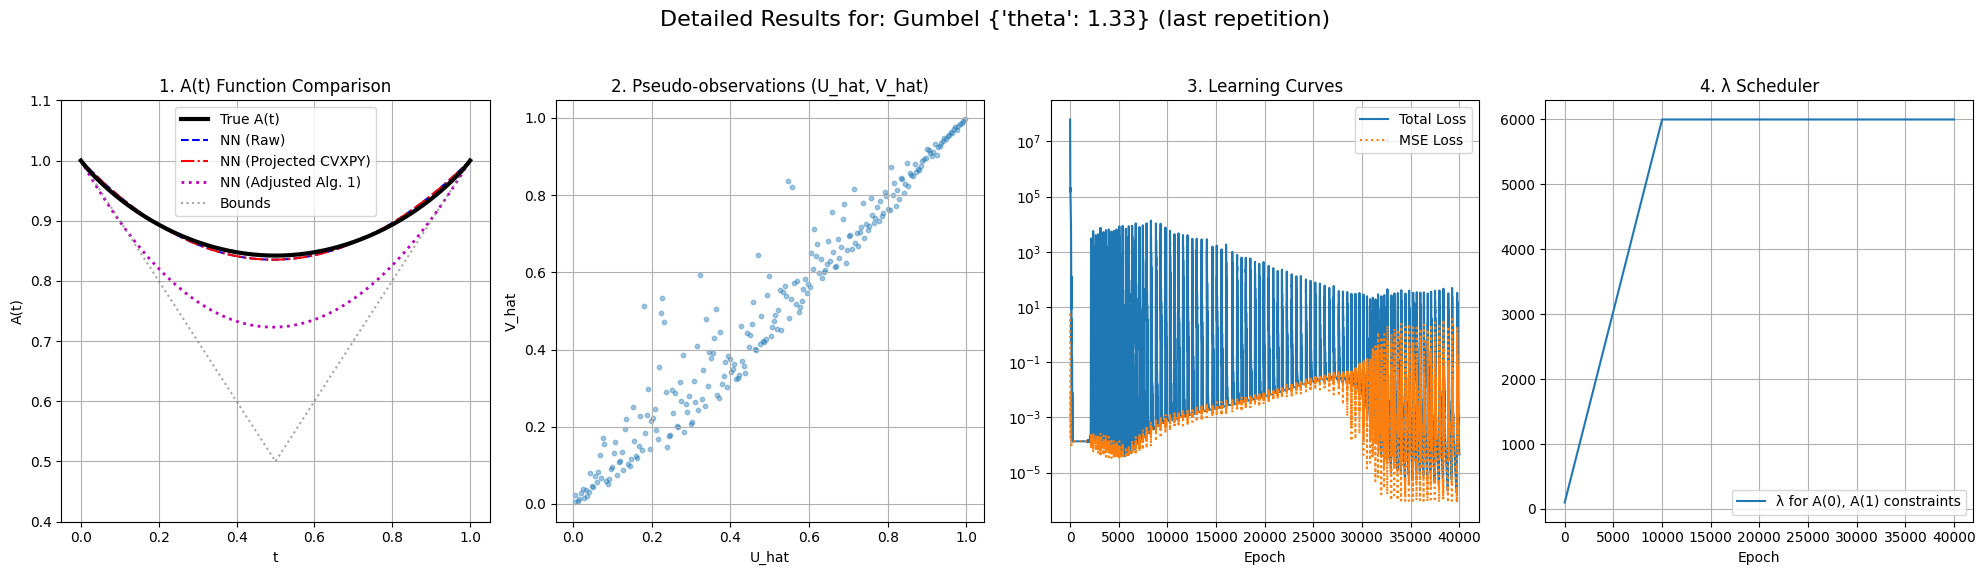


 STARTING SCENARIO: Gumbel {'theta': 2} (Tau ≈ 0.500)
[*] MAX_LAMBDA_A_BOUNDS adjusted for this scenario: 15000.0
--- Repetition 1/10 ---
-> Rep 1 finished. Duration: 39.36s. Raw MSE: 5.568e-02, Proj MSE: 7.388e-03, Adj MSE: 5.568e-02
--- Repetition 2/10 ---
-> Rep 2 finished. Duration: 39.07s. Raw MSE: 6.111e-05, Proj MSE: 4.714e-05, Adj MSE: 6.111e-05
--- Repetition 3/10 ---
-> Rep 3 finished. Duration: 39.46s. Raw MSE: 6.693e-05, Proj MSE: 5.244e-05, Adj MSE: 6.695e-05
--- Repetition 4/10 ---
-> Rep 4 finished. Duration: 39.51s. Raw MSE: 5.241e-05, Proj MSE: 4.023e-05, Adj MSE: 5.241e-05
--- Repetition 5/10 ---
-> Rep 5 finished. Duration: 40.32s. Raw MSE: 6.305e-05, Proj MSE: 4.735e-05, Adj MSE: 6.304e-05
--- Repetition 6/10 ---
-> Rep 6 finished. Duration: 43.03s. Raw MSE: 8.917e-05, Proj MSE: 7.062e-05, Adj MSE: 8.917e-05
--- Repetition 7/10 ---
-> Rep 7 finished. Duration: 44.63s. Raw MSE: 1.965e-03, Proj MSE: 1.378e-03, Adj MSE: 1.965e-03
--- Repetition 8/10 ---
-> Rep 8 finis

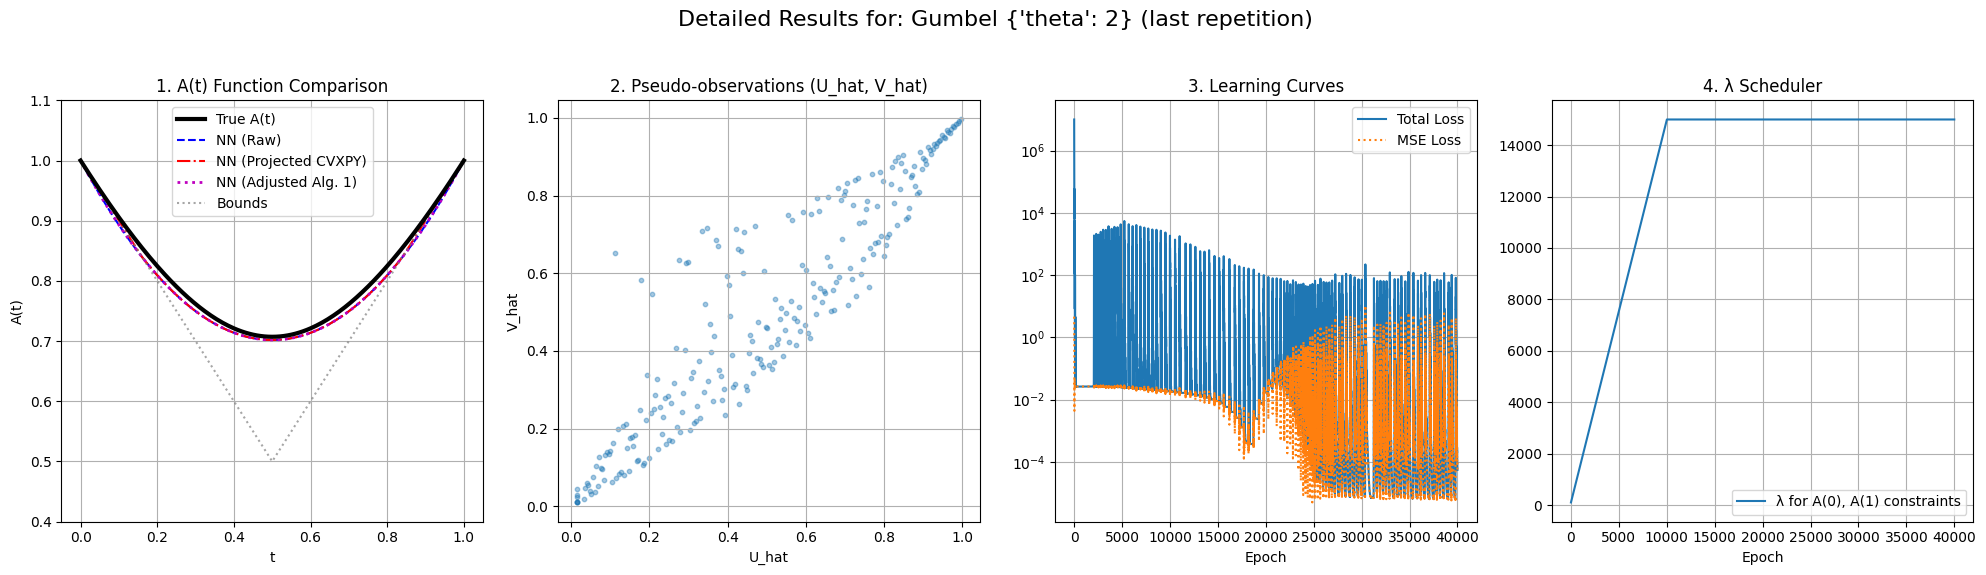


 STARTING SCENARIO: Gumbel {'theta': 4.0} (Tau ≈ 0.750)
[*] MAX_LAMBDA_A_BOUNDS adjusted for this scenario: 15000.0
--- Repetition 1/10 ---
-> Rep 1 finished. Duration: 45.94s. Raw MSE: 5.897e-03, Proj MSE: 1.549e-03, Adj MSE: 5.897e-03
--- Repetition 2/10 ---
-> Rep 2 finished. Duration: 44.92s. Raw MSE: 1.079e-03, Proj MSE: 4.352e-05, Adj MSE: 1.079e-03
--- Repetition 3/10 ---
-> Rep 3 finished. Duration: 45.77s. Raw MSE: 8.737e-04, Proj MSE: 8.272e-05, Adj MSE: 8.738e-04
--- Repetition 4/10 ---
-> Rep 4 finished. Duration: 67.92s. Raw MSE: 1.094e-03, Proj MSE: 4.222e-05, Adj MSE: 1.094e-03
--- Repetition 5/10 ---
-> Rep 5 finished. Duration: 45.47s. Raw MSE: 8.981e-04, Proj MSE: 7.972e-05, Adj MSE: 8.980e-04
--- Repetition 6/10 ---
-> Rep 6 finished. Duration: 47.71s. Raw MSE: 1.014e-03, Proj MSE: 7.103e-05, Adj MSE: 1.014e-03
--- Repetition 7/10 ---
-> Rep 7 finished. Duration: 47.25s. Raw MSE: 1.054e-03, Proj MSE: 4.741e-05, Adj MSE: 1.054e-03
--- Repetition 8/10 ---
-> Rep 8 fin

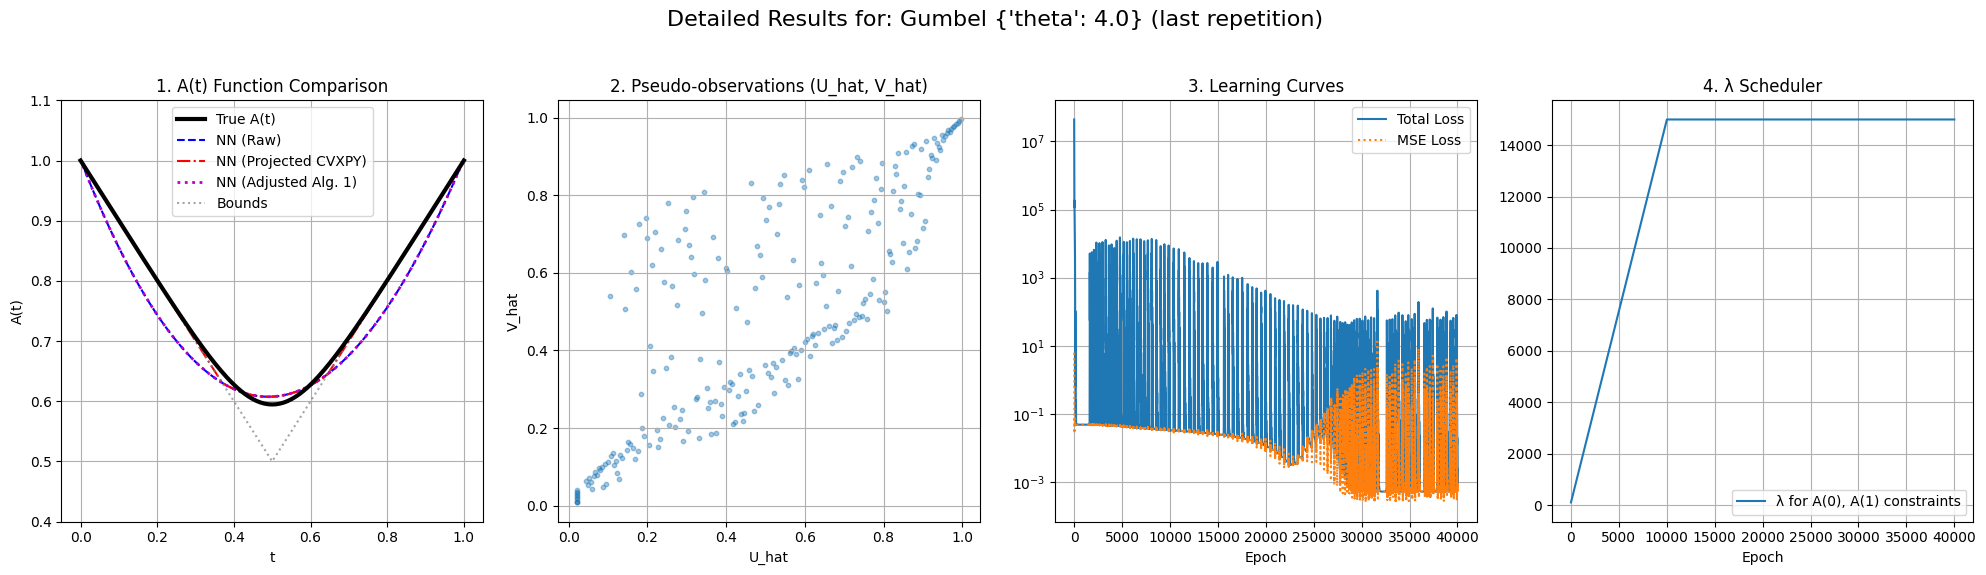


 STARTING SCENARIO: Gumbel {'theta': 10.0} (Tau ≈ 0.900)
[*] MAX_LAMBDA_A_BOUNDS adjusted for this scenario: 15000.0
--- Repetition 1/10 ---
-> Rep 1 finished. Duration: 45.93s. Raw MSE: 6.787e-03, Proj MSE: 1.083e-05, Adj MSE: 6.787e-03
--- Repetition 2/10 ---
-> Rep 2 finished. Duration: 46.25s. Raw MSE: 1.946e-03, Proj MSE: 2.628e-04, Adj MSE: 1.946e-03
--- Repetition 3/10 ---
-> Rep 3 finished. Duration: 46.08s. Raw MSE: 2.212e-03, Proj MSE: 1.606e-04, Adj MSE: 2.212e-03
--- Repetition 4/10 ---
-> Rep 4 finished. Duration: 46.07s. Raw MSE: 2.302e-03, Proj MSE: 1.351e-04, Adj MSE: 2.302e-03
--- Repetition 5/10 ---
-> Rep 5 finished. Duration: 45.87s. Raw MSE: 2.202e-03, Proj MSE: 1.780e-04, Adj MSE: 2.202e-03
--- Repetition 6/10 ---
-> Rep 6 finished. Duration: 46.61s. Raw MSE: 2.031e-03, Proj MSE: 2.092e-04, Adj MSE: 2.031e-03
--- Repetition 7/10 ---
-> Rep 7 finished. Duration: 48.67s. Raw MSE: 1.455e-03, Proj MSE: 1.430e-04, Adj MSE: 1.455e-03
--- Repetition 8/10 ---
-> Rep 8 fi

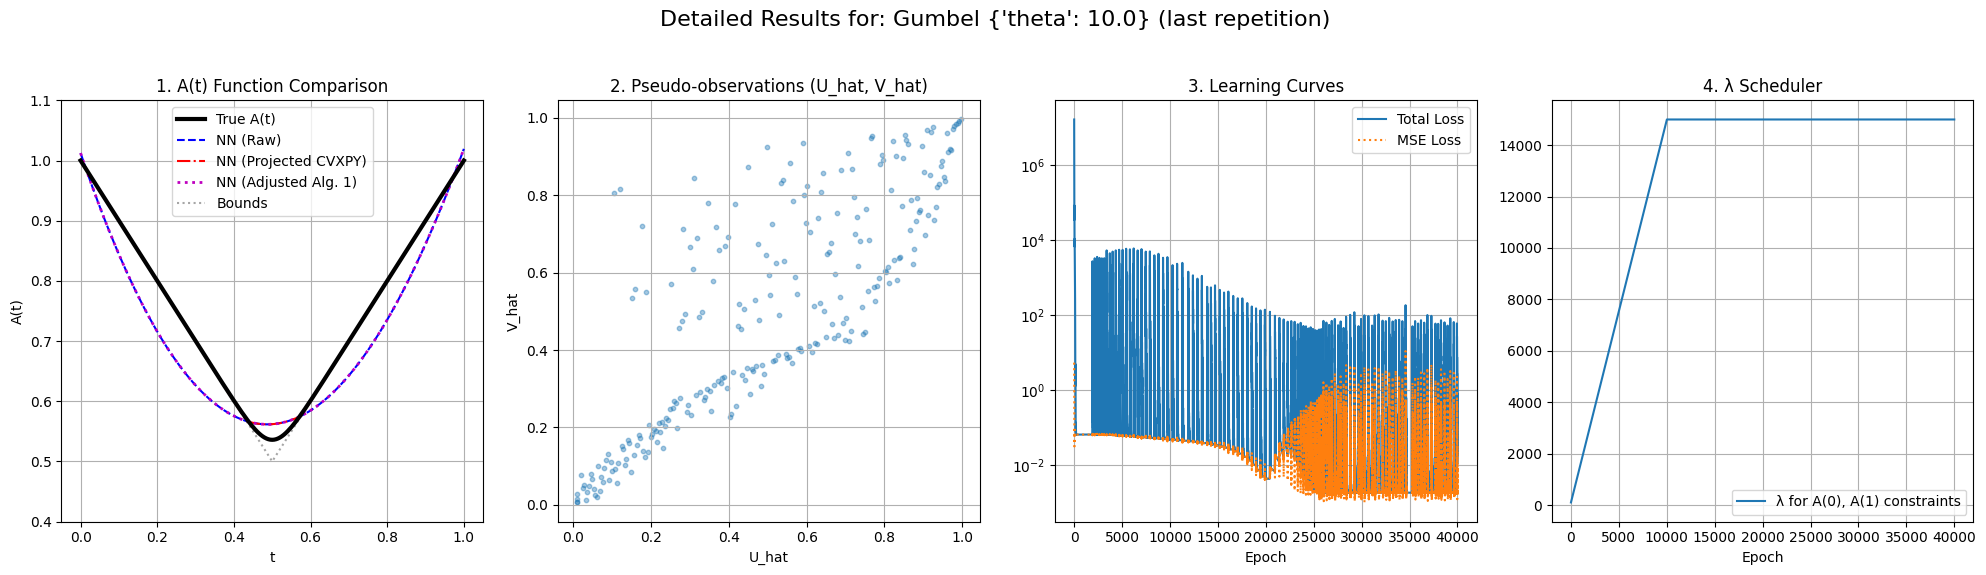


 STARTING SCENARIO: Galambos {'theta': 0.33} (Tau ≈ 0.248)
[*] MAX_LAMBDA_A_BOUNDS adjusted for this scenario: 2000.0
--- Repetition 1/10 ---
-> Rep 1 finished. Duration: 45.62s. Raw MSE: 2.060e-02, Proj MSE: 2.264e-03, Adj MSE: 4.287e-01
--- Repetition 2/10 ---
-> Rep 2 finished. Duration: 48.61s. Raw MSE: 5.125e-05, Proj MSE: 5.071e-05, Adj MSE: 5.657e-02
--- Repetition 3/10 ---
-> Rep 3 finished. Duration: 53.31s. Raw MSE: 1.807e-05, Proj MSE: 1.805e-05, Adj MSE: 2.765e-02
--- Repetition 4/10 ---
-> Rep 4 finished. Duration: 47.53s. Raw MSE: 1.885e-05, Proj MSE: 1.883e-05, Adj MSE: 2.755e-02
--- Repetition 5/10 ---
-> Rep 5 finished. Duration: 50.21s. Raw MSE: 2.437e-05, Proj MSE: 2.432e-05, Adj MSE: 3.338e-02
--- Repetition 6/10 ---
-> Rep 6 finished. Duration: 48.43s. Raw MSE: 2.505e-03, Proj MSE: 1.463e-03, Adj MSE: 2.601e-02
--- Repetition 7/10 ---
-> Rep 7 finished. Duration: 49.12s. Raw MSE: 1.985e-05, Proj MSE: 1.980e-05, Adj MSE: 3.237e-02
--- Repetition 8/10 ---
-> Rep 8 f

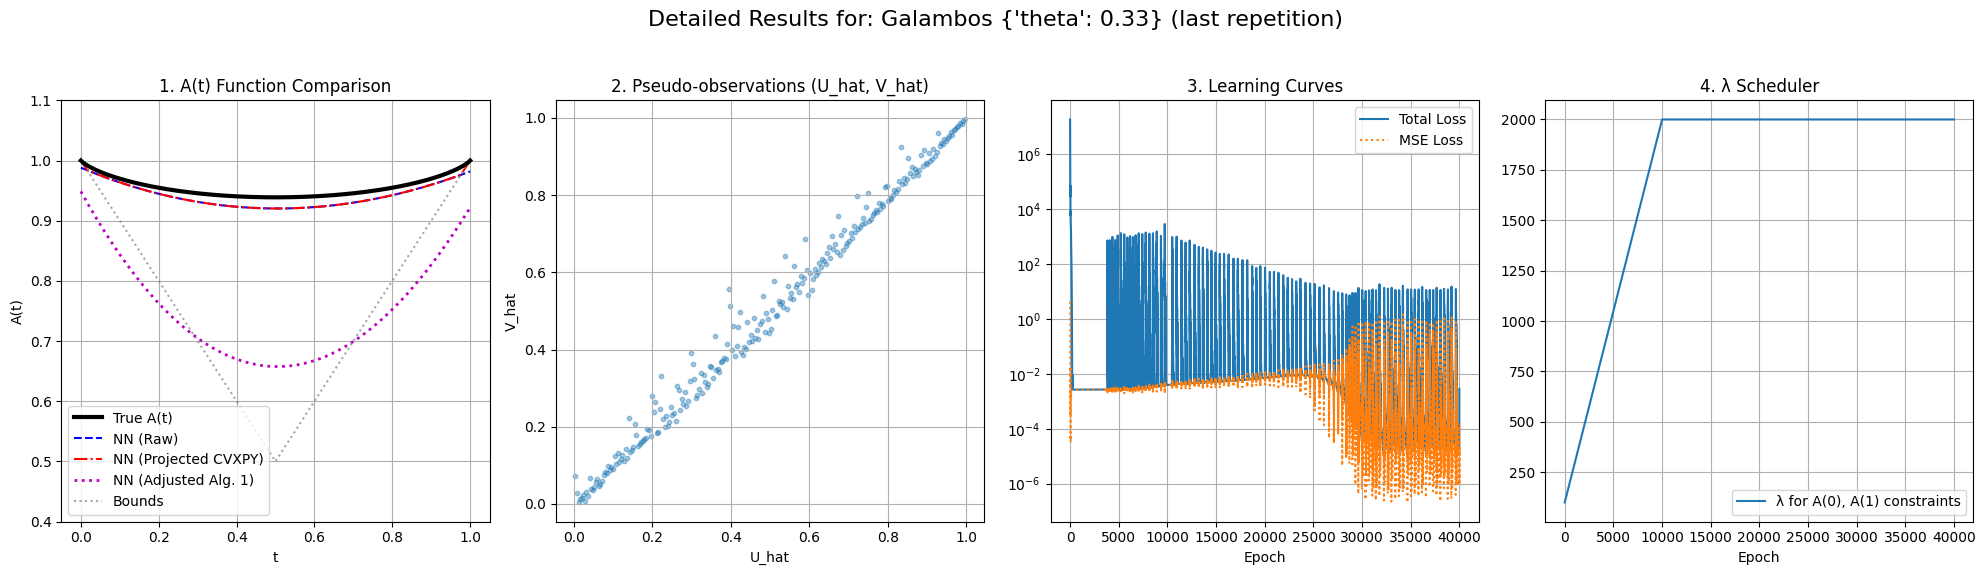


 STARTING SCENARIO: Galambos {'theta': 1.0} (Tau ≈ 0.500)
[*] MAX_LAMBDA_A_BOUNDS adjusted for this scenario: 6000.0
--- Repetition 1/10 ---
-> Rep 1 finished. Duration: 47.42s. Raw MSE: 6.070e-08, Proj MSE: 6.069e-08, Adj MSE: 2.000e-03
--- Repetition 2/10 ---
-> Rep 2 finished. Duration: 47.28s. Raw MSE: 4.238e-06, Proj MSE: 4.235e-06, Adj MSE: 2.005e-03
--- Repetition 3/10 ---
-> Rep 3 finished. Duration: 47.14s. Raw MSE: 3.655e-02, Proj MSE: 1.590e-02, Adj MSE: 3.655e-02
--- Repetition 4/10 ---
-> Rep 4 finished. Duration: 49.67s. Raw MSE: 5.464e-04, Proj MSE: 5.364e-04, Adj MSE: 5.464e-04
--- Repetition 5/10 ---
-> Rep 5 finished. Duration: 50.96s. Raw MSE: 5.608e-07, Proj MSE: 5.608e-07, Adj MSE: 2.001e-03
--- Repetition 6/10 ---
-> Rep 6 finished. Duration: 47.05s. Raw MSE: 5.270e-07, Proj MSE: 5.270e-07, Adj MSE: 1.836e-03
--- Repetition 7/10 ---
-> Rep 7 finished. Duration: 39.51s. Raw MSE: 6.843e-03, Proj MSE: 4.436e-03, Adj MSE: 6.843e-03
--- Repetition 8/10 ---
-> Rep 8 fi

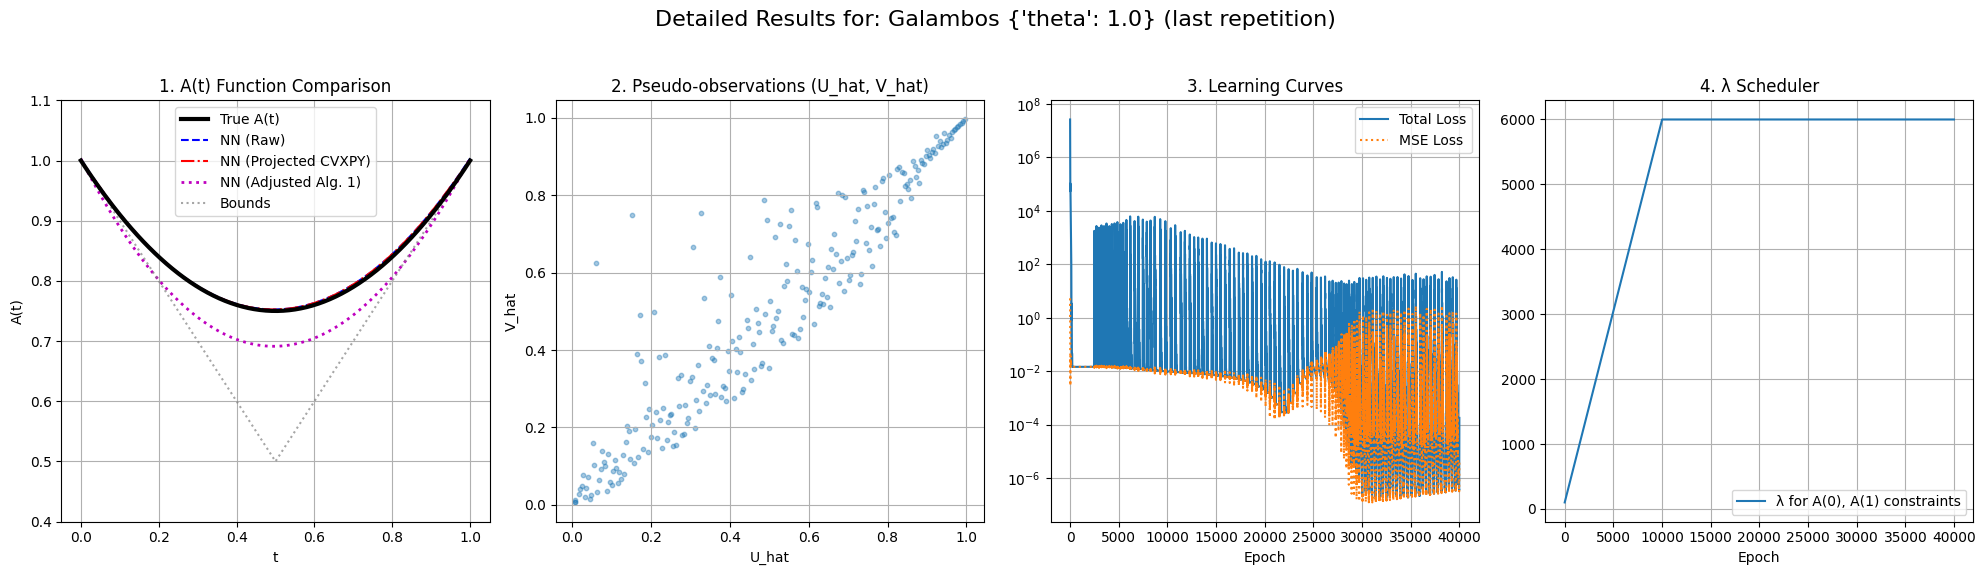


 STARTING SCENARIO: Galambos {'theta': 3.0} (Tau ≈ 0.750)
[*] MAX_LAMBDA_A_BOUNDS adjusted for this scenario: 12000.0
--- Repetition 1/10 ---
-> Rep 1 finished. Duration: 42.73s. Raw MSE: 2.144e+00, Proj MSE: 6.935e-02, Adj MSE: 2.144e+00
--- Repetition 2/10 ---
-> Rep 2 finished. Duration: 43.13s. Raw MSE: 7.975e-04, Proj MSE: 5.443e-05, Adj MSE: 7.975e-04
--- Repetition 3/10 ---
-> Rep 3 finished. Duration: 43.00s. Raw MSE: 9.351e-04, Proj MSE: 4.243e-05, Adj MSE: 9.351e-04
--- Repetition 4/10 ---
-> Rep 4 finished. Duration: 43.12s. Raw MSE: 8.780e-04, Proj MSE: 4.633e-05, Adj MSE: 8.780e-04
--- Repetition 5/10 ---
-> Rep 5 finished. Duration: 42.82s. Raw MSE: 8.883e-04, Proj MSE: 3.905e-05, Adj MSE: 8.882e-04
--- Repetition 6/10 ---
-> Rep 6 finished. Duration: 42.95s. Raw MSE: 7.641e-04, Proj MSE: 6.484e-05, Adj MSE: 7.640e-04
--- Repetition 7/10 ---
-> Rep 7 finished. Duration: 42.73s. Raw MSE: 8.221e-04, Proj MSE: 5.421e-05, Adj MSE: 8.221e-04
--- Repetition 8/10 ---
-> Rep 8 f

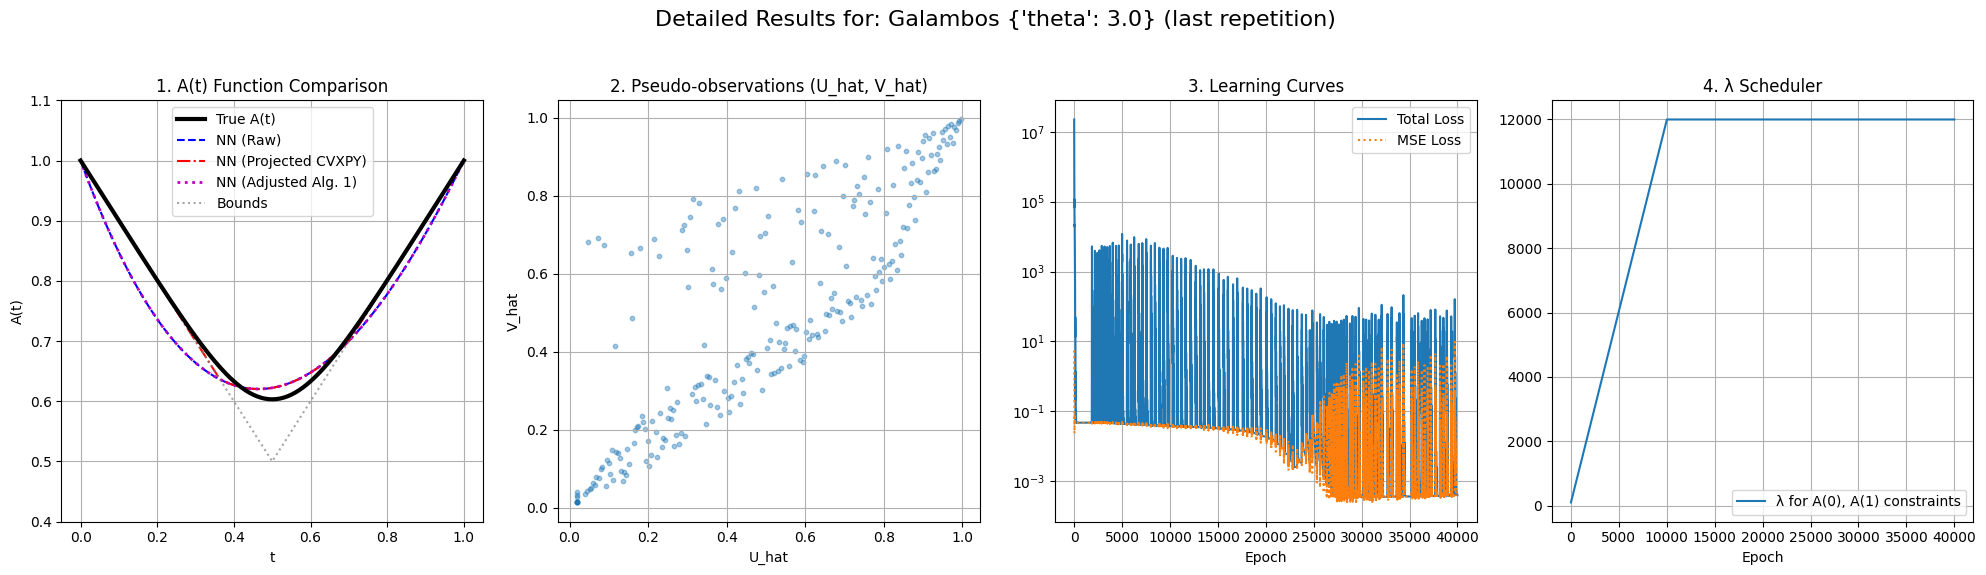


 STARTING SCENARIO: Galambos {'theta': 9.0} (Tau ≈ 0.900)
[*] MAX_LAMBDA_A_BOUNDS adjusted for this scenario: 12000.0
--- Repetition 1/10 ---
-> Rep 1 finished. Duration: 43.93s. Raw MSE: 2.527e-03, Proj MSE: 1.097e-04, Adj MSE: 2.527e-03
--- Repetition 2/10 ---
-> Rep 2 finished. Duration: 43.88s. Raw MSE: 2.248e-03, Proj MSE: 1.527e-04, Adj MSE: 2.248e-03
--- Repetition 3/10 ---
-> Rep 3 finished. Duration: 44.32s. Raw MSE: 2.205e-03, Proj MSE: 1.524e-04, Adj MSE: 2.205e-03
--- Repetition 4/10 ---
-> Rep 4 finished. Duration: 43.90s. Raw MSE: 1.786e-03, Proj MSE: 2.740e-04, Adj MSE: 1.786e-03
--- Repetition 5/10 ---
-> Rep 5 finished. Duration: 43.91s. Raw MSE: 1.934e-03, Proj MSE: 2.469e-04, Adj MSE: 1.934e-03
--- Repetition 6/10 ---
-> Rep 6 finished. Duration: 43.96s. Raw MSE: 2.000e-03, Proj MSE: 2.213e-04, Adj MSE: 2.000e-03
--- Repetition 7/10 ---
-> Rep 7 finished. Duration: 43.97s. Raw MSE: 5.230e-01, Proj MSE: 4.578e-05, Adj MSE: 5.230e-01
--- Repetition 8/10 ---
-> Rep 8 f

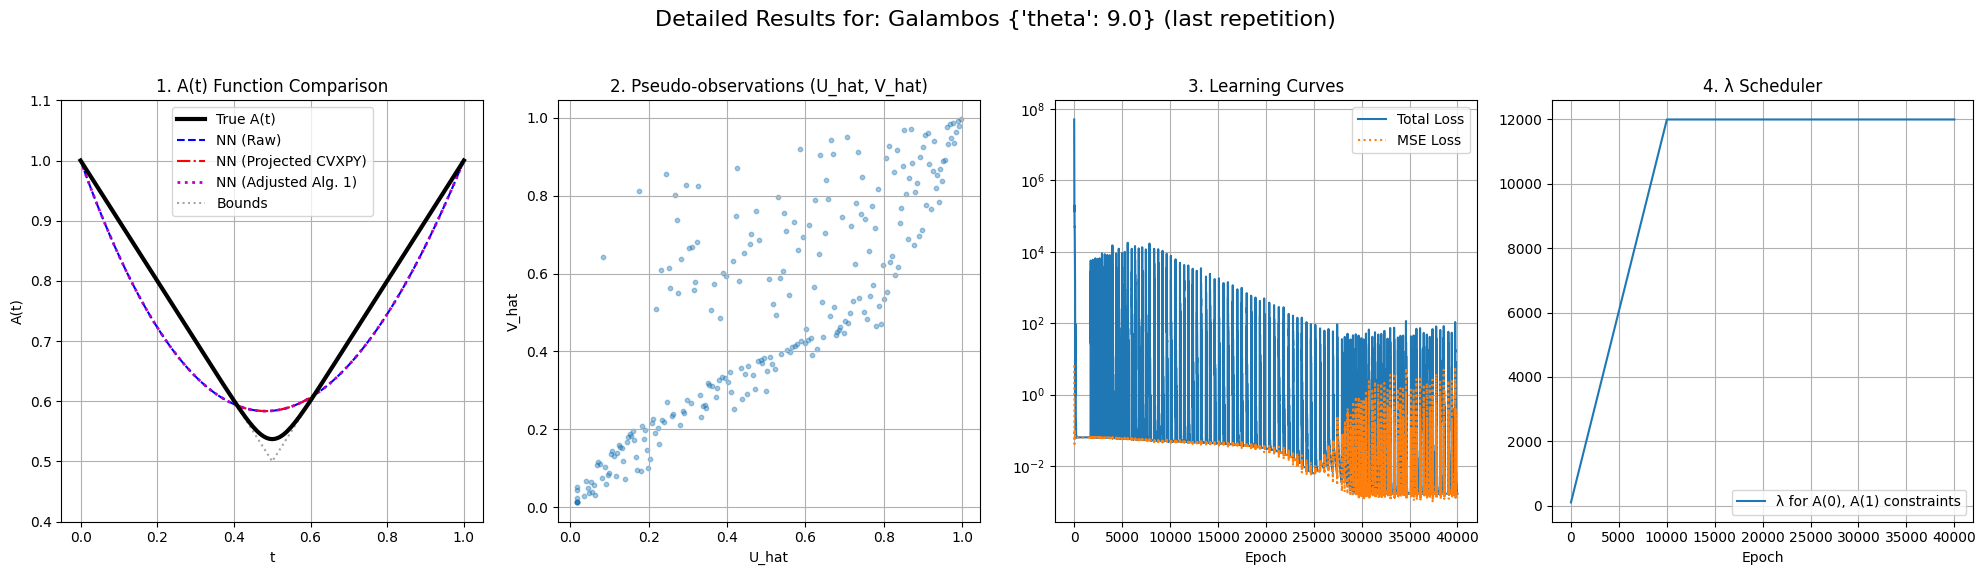


 STARTING SCENARIO: Tawn {'alpha': 0.8, 'beta': 0.1, 'psi': 10} (Tau ≈ 2.823)
[*] MAX_LAMBDA_A_BOUNDS adjusted for this scenario: 12000.0
--- Repetition 1/10 ---
-> Rep 1 finished. Duration: 42.88s. Raw MSE: 6.472e-04, Proj MSE: 6.472e-04, Adj MSE: 3.846e-02
--- Repetition 2/10 ---
-> Rep 2 finished. Duration: 43.00s. Raw MSE: 8.193e-04, Proj MSE: 8.193e-04, Adj MSE: 9.904e-02
--- Repetition 3/10 ---
-> Rep 3 finished. Duration: 43.18s. Raw MSE: 8.719e-04, Proj MSE: 8.625e-04, Adj MSE: 1.990e-02
--- Repetition 4/10 ---
-> Rep 4 finished. Duration: 44.47s. Raw MSE: 6.342e-04, Proj MSE: 6.342e-04, Adj MSE: 1.075e-01
--- Repetition 5/10 ---
-> Rep 5 finished. Duration: 44.17s. Raw MSE: 7.564e-04, Proj MSE: 7.564e-04, Adj MSE: 5.316e-02
--- Repetition 6/10 ---
-> Rep 6 finished. Duration: 44.61s. Raw MSE: 2.691e-03, Proj MSE: 2.126e-03, Adj MSE: 2.645e+00
--- Repetition 7/10 ---
-> Rep 7 finished. Duration: 44.34s. Raw MSE: 6.131e-04, Proj MSE: 6.131e-04, Adj MSE: 2.094e-01
--- Repetition

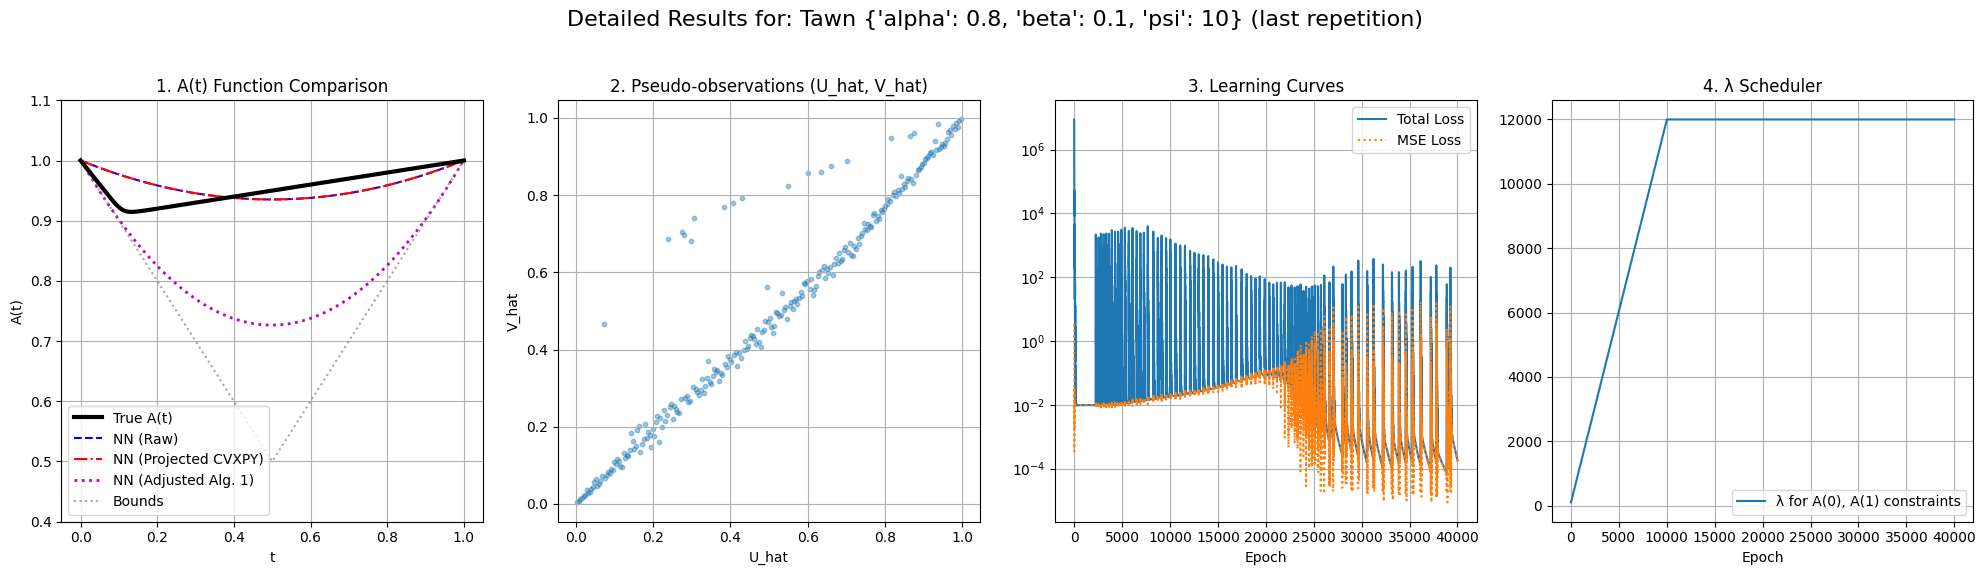


 STARTING SCENARIO: Tawn {'alpha': 0.8, 'beta': 0.34, 'psi': 10} (Tau ≈ 2.526)
[*] MAX_LAMBDA_A_BOUNDS adjusted for this scenario: 12000.0
--- Repetition 1/10 ---
-> Rep 1 finished. Duration: 44.28s. Raw MSE: 3.791e-02, Proj MSE: 2.091e-02, Adj MSE: 1.082e-01
--- Repetition 2/10 ---
-> Rep 2 finished. Duration: 44.55s. Raw MSE: 2.174e-03, Proj MSE: 1.977e-03, Adj MSE: 2.174e-03
--- Repetition 3/10 ---
-> Rep 3 finished. Duration: 44.54s. Raw MSE: 3.676e-03, Proj MSE: 3.675e-03, Adj MSE: 1.399e-02
--- Repetition 4/10 ---
-> Rep 4 finished. Duration: 44.29s. Raw MSE: 2.169e-03, Proj MSE: 2.168e-03, Adj MSE: 8.337e-03
--- Repetition 5/10 ---
-> Rep 5 finished. Duration: 44.08s. Raw MSE: 1.527e-03, Proj MSE: 1.527e-03, Adj MSE: 4.754e-03
--- Repetition 6/10 ---
-> Rep 6 finished. Duration: 44.36s. Raw MSE: 2.201e-03, Proj MSE: 2.200e-03, Adj MSE: 8.738e-03
--- Repetition 7/10 ---
-> Rep 7 finished. Duration: 44.13s. Raw MSE: 1.557e-03, Proj MSE: 1.557e-03, Adj MSE: 1.866e-02
--- Repetitio

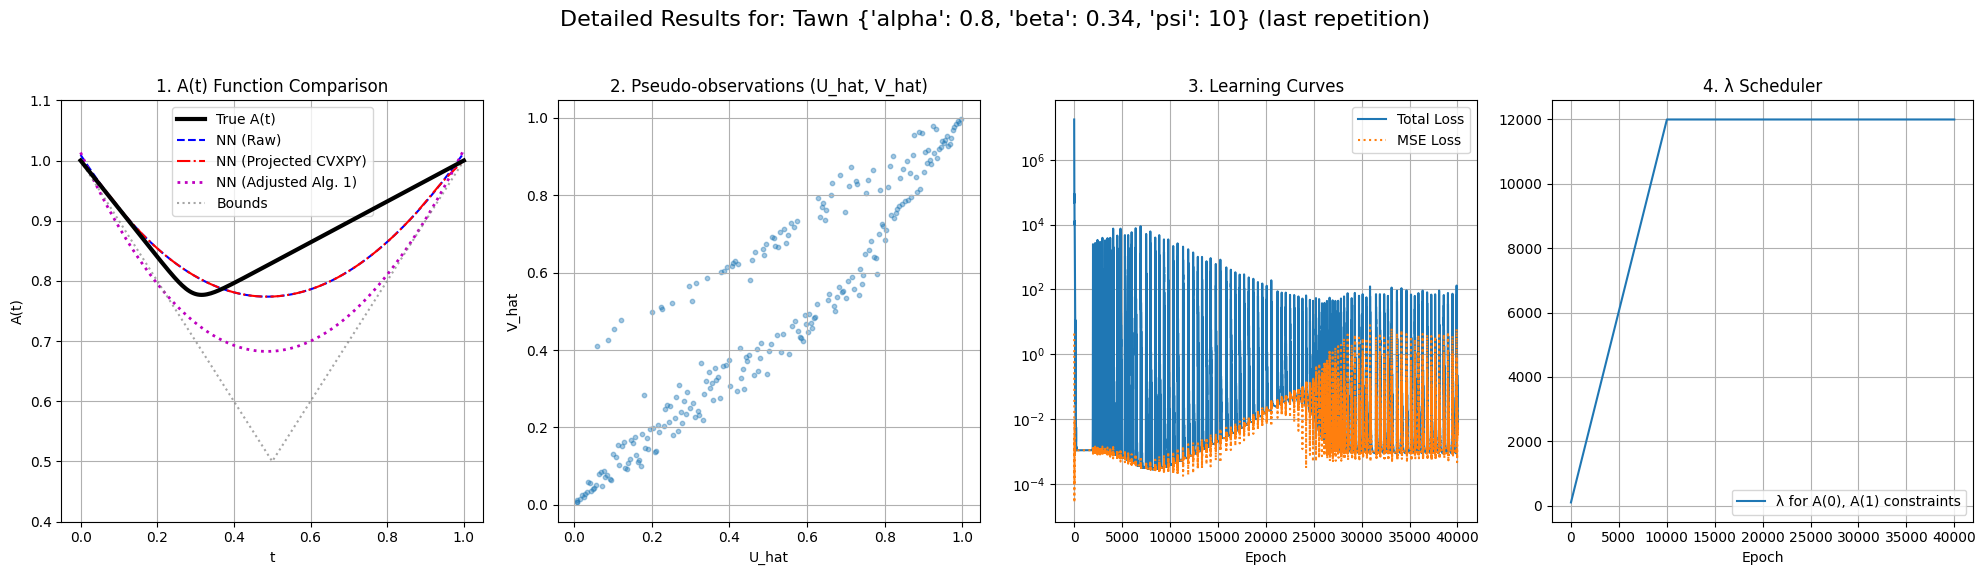


 STARTING SCENARIO: Tawn {'alpha': 0.8, 'beta': 0.75, 'psi': 10} (Tau ≈ 2.233)
[*] MAX_LAMBDA_A_BOUNDS adjusted for this scenario: 12000.0
--- Repetition 1/10 ---
-> Rep 1 finished. Duration: 44.17s. Raw MSE: 1.600e-03, Proj MSE: 1.089e-03, Adj MSE: 1.600e-03
--- Repetition 2/10 ---
-> Rep 2 finished. Duration: 44.14s. Raw MSE: 2.199e-02, Proj MSE: 4.437e-03, Adj MSE: 2.199e-02
--- Repetition 3/10 ---
-> Rep 3 finished. Duration: 44.19s. Raw MSE: 4.282e-03, Proj MSE: 1.993e-03, Adj MSE: 4.282e-03
--- Repetition 4/10 ---
-> Rep 4 finished. Duration: 44.07s. Raw MSE: 1.675e-03, Proj MSE: 1.127e-03, Adj MSE: 1.675e-03
--- Repetition 5/10 ---
-> Rep 5 finished. Duration: 44.10s. Raw MSE: 1.760e-03, Proj MSE: 1.165e-03, Adj MSE: 1.760e-03
--- Repetition 6/10 ---
-> Rep 6 finished. Duration: 43.97s. Raw MSE: 1.906e-03, Proj MSE: 1.220e-03, Adj MSE: 1.906e-03
--- Repetition 7/10 ---
-> Rep 7 finished. Duration: 44.00s. Raw MSE: 1.315e-02, Proj MSE: 3.642e-03, Adj MSE: 1.315e-02
--- Repetitio

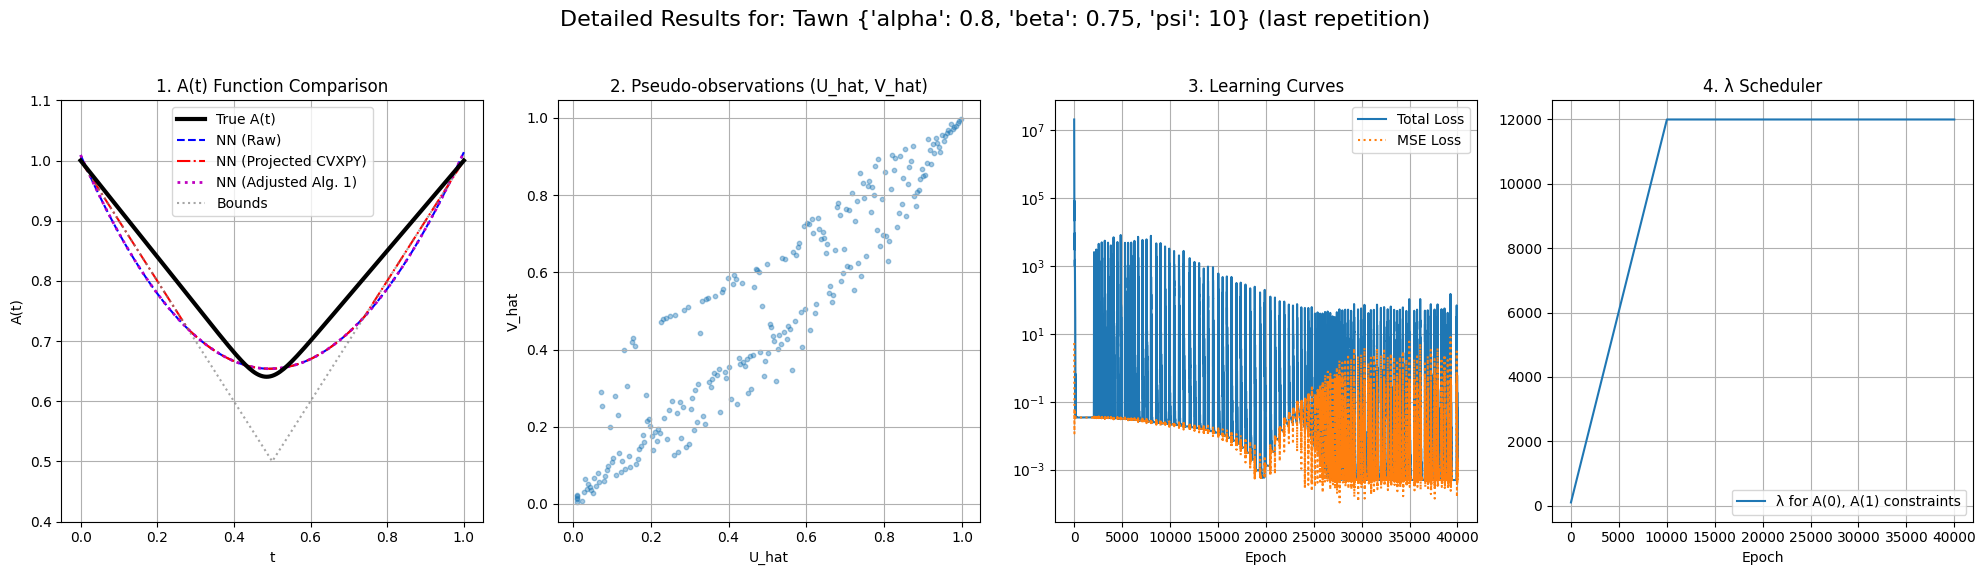


 STARTING SCENARIO: Tawn {'alpha': 0.8, 'beta': 0.9, 'psi': 10} (Tau ≈ 2.160)
[*] MAX_LAMBDA_A_BOUNDS adjusted for this scenario: 12000.0
--- Repetition 1/10 ---
-> Rep 1 finished. Duration: 44.26s. Raw MSE: 2.245e-03, Proj MSE: 8.826e-04, Adj MSE: 2.245e-03
--- Repetition 2/10 ---
-> Rep 2 finished. Duration: 44.20s. Raw MSE: 2.565e-03, Proj MSE: 9.275e-04, Adj MSE: 2.565e-03
--- Repetition 3/10 ---
-> Rep 3 finished. Duration: 44.09s. Raw MSE: 3.635e-03, Proj MSE: 1.076e-03, Adj MSE: 3.635e-03
--- Repetition 4/10 ---
-> Rep 4 finished. Duration: 44.04s. Raw MSE: 2.518e-03, Proj MSE: 9.545e-04, Adj MSE: 2.518e-03
--- Repetition 5/10 ---
-> Rep 5 finished. Duration: 44.04s. Raw MSE: 3.930e-01, Proj MSE: 2.427e-03, Adj MSE: 6.367e-01
--- Repetition 6/10 ---
-> Rep 6 finished. Duration: 44.47s. Raw MSE: 2.389e-03, Proj MSE: 9.034e-04, Adj MSE: 2.388e-03
--- Repetition 7/10 ---
-> Rep 7 finished. Duration: 44.34s. Raw MSE: 3.387e-02, Proj MSE: 2.427e-03, Adj MSE: 3.387e-02
--- Repetition

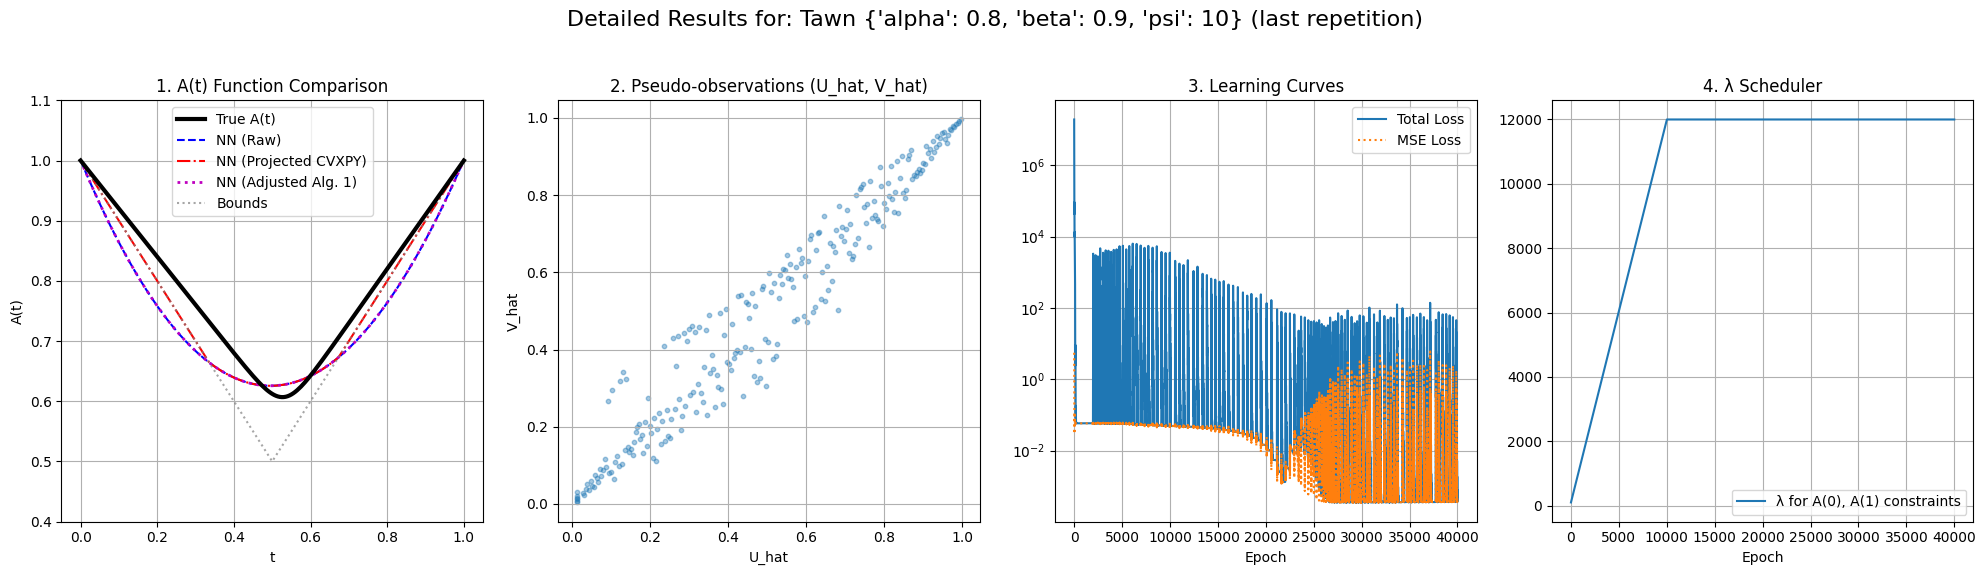


 STARTING SCENARIO: Tawn {'alpha': 0.1, 'beta': 0.9, 'psi': 4} (Tau ≈ 2.824)
[*] MAX_LAMBDA_A_BOUNDS adjusted for this scenario: 12000.0
--- Repetition 1/10 ---
-> Rep 1 finished. Duration: 44.46s. Raw MSE: 1.079e-03, Proj MSE: 1.079e-03, Adj MSE: 4.697e-02
--- Repetition 2/10 ---
-> Rep 2 finished. Duration: 44.14s. Raw MSE: 2.025e-03, Proj MSE: 2.021e-03, Adj MSE: 5.570e-02
--- Repetition 3/10 ---
-> Rep 3 finished. Duration: 45.12s. Raw MSE: 2.488e-03, Proj MSE: 1.808e-03, Adj MSE: 1.140e-02
--- Repetition 4/10 ---
-> Rep 4 finished. Duration: 44.66s. Raw MSE: 9.895e-04, Proj MSE: 9.888e-04, Adj MSE: 2.157e-02
--- Repetition 5/10 ---
-> Rep 5 finished. Duration: 44.32s. Raw MSE: 5.994e-04, Proj MSE: 5.994e-04, Adj MSE: 6.017e-02
--- Repetition 6/10 ---
-> Rep 6 finished. Duration: 44.01s. Raw MSE: 5.897e-04, Proj MSE: 5.897e-04, Adj MSE: 3.654e-01
--- Repetition 7/10 ---
-> Rep 7 finished. Duration: 44.20s. Raw MSE: 1.347e-03, Proj MSE: 1.343e-03, Adj MSE: 2.030e+00
--- Repetition 

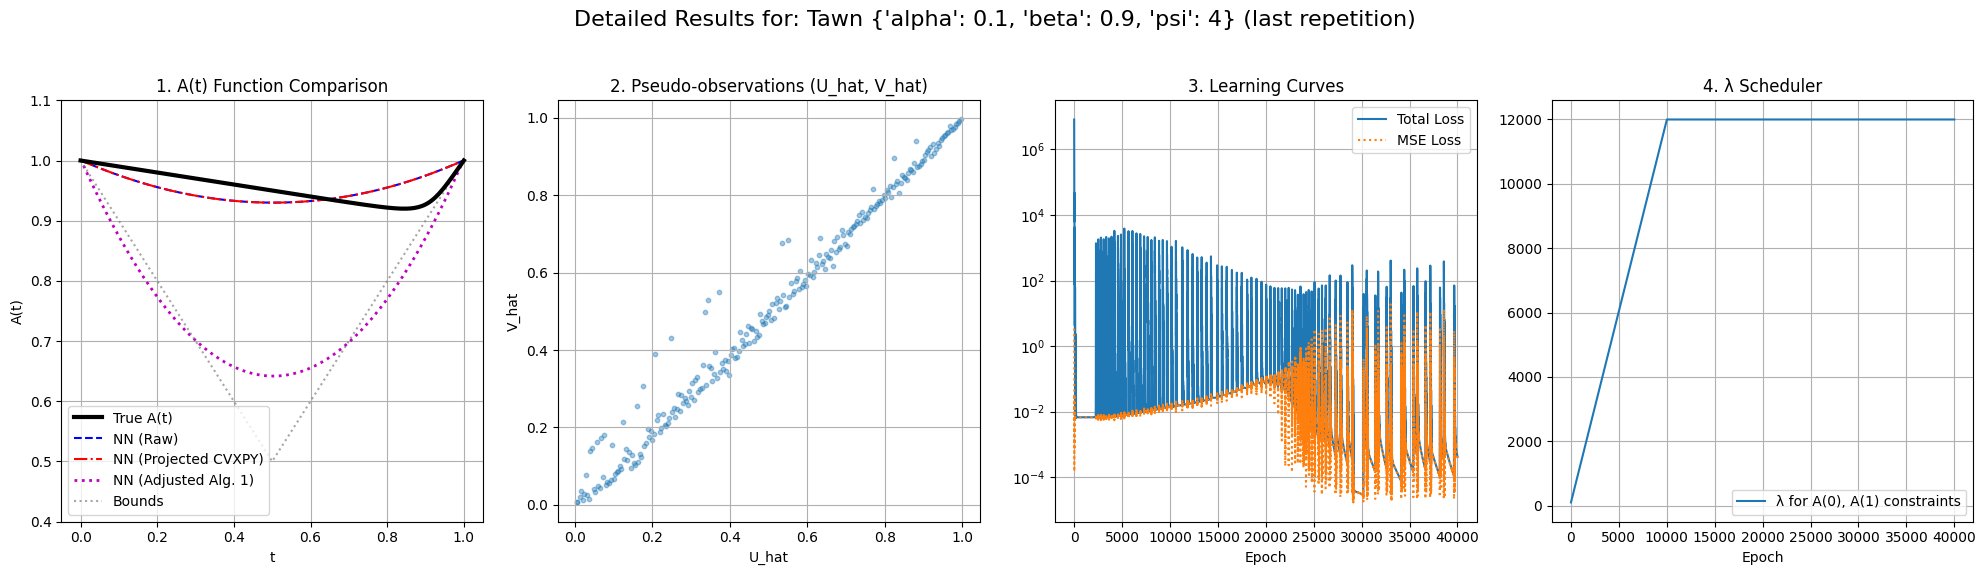


 STARTING SCENARIO: Tawn {'alpha': 0.35, 'beta': 0.9, 'psi': 4} (Tau ≈ 2.521)
[*] MAX_LAMBDA_A_BOUNDS adjusted for this scenario: 12000.0
--- Repetition 1/10 ---
-> Rep 1 finished. Duration: 44.08s. Raw MSE: 1.968e-02, Proj MSE: 1.489e-02, Adj MSE: 7.023e-02
--- Repetition 2/10 ---
-> Rep 2 finished. Duration: 44.42s. Raw MSE: 1.427e-03, Proj MSE: 1.427e-03, Adj MSE: 4.594e-03
--- Repetition 3/10 ---
-> Rep 3 finished. Duration: 44.28s. Raw MSE: 1.566e-03, Proj MSE: 1.566e-03, Adj MSE: 2.041e-02
--- Repetition 4/10 ---
-> Rep 4 finished. Duration: 44.24s. Raw MSE: 4.717e-02, Proj MSE: 2.351e-02, Adj MSE: 1.377e-01
--- Repetition 5/10 ---
-> Rep 5 finished. Duration: 44.48s. Raw MSE: 1.341e-03, Proj MSE: 1.341e-03, Adj MSE: 1.354e-02
--- Repetition 6/10 ---
-> Rep 6 finished. Duration: 44.37s. Raw MSE: 1.543e-03, Proj MSE: 1.543e-03, Adj MSE: 2.012e-02
--- Repetition 7/10 ---
-> Rep 7 finished. Duration: 44.12s. Raw MSE: 7.744e-02, Proj MSE: 2.678e-02, Adj MSE: 1.896e-01
--- Repetition

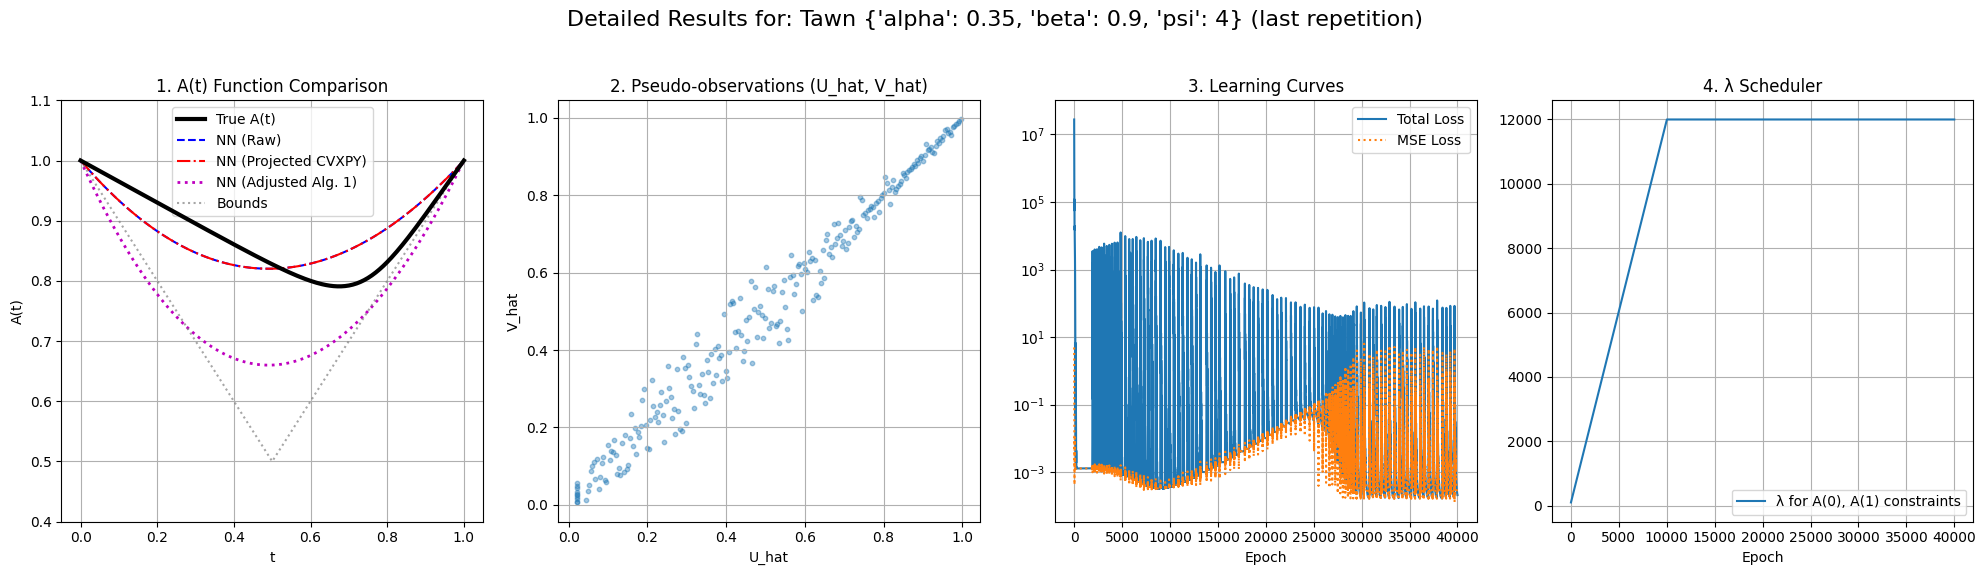


 STARTING SCENARIO: Tawn {'alpha': 0.88, 'beta': 0.9, 'psi': 4} (Tau ≈ 2.162)
[*] MAX_LAMBDA_A_BOUNDS adjusted for this scenario: 12000.0
--- Repetition 1/10 ---
-> Rep 1 finished. Duration: 940.24s. Raw MSE: 1.013e-02, Proj MSE: 7.859e-03, Adj MSE: 1.013e-02
--- Repetition 2/10 ---
-> Rep 2 finished. Duration: 39.74s. Raw MSE: 1.353e-03, Proj MSE: 4.286e-04, Adj MSE: 1.353e-03
--- Repetition 3/10 ---
-> Rep 3 finished. Duration: 47.94s. Raw MSE: 8.786e-04, Proj MSE: 3.269e-04, Adj MSE: 8.787e-04
--- Repetition 4/10 ---
-> Rep 4 finished. Duration: 45.25s. Raw MSE: 4.218e-01, Proj MSE: 5.627e-02, Adj MSE: 4.218e-01
--- Repetition 5/10 ---
-> Rep 5 finished. Duration: 45.52s. Raw MSE: 1.351e-03, Proj MSE: 4.305e-04, Adj MSE: 1.351e-03
--- Repetition 6/10 ---
-> Rep 6 finished. Duration: 44.90s. Raw MSE: 1.360e-03, Proj MSE: 4.434e-04, Adj MSE: 1.360e-03
--- Repetition 7/10 ---
-> Rep 7 finished. Duration: 45.37s. Raw MSE: 1.748e-02, Proj MSE: 6.304e-03, Adj MSE: 1.748e-02
--- Repetitio

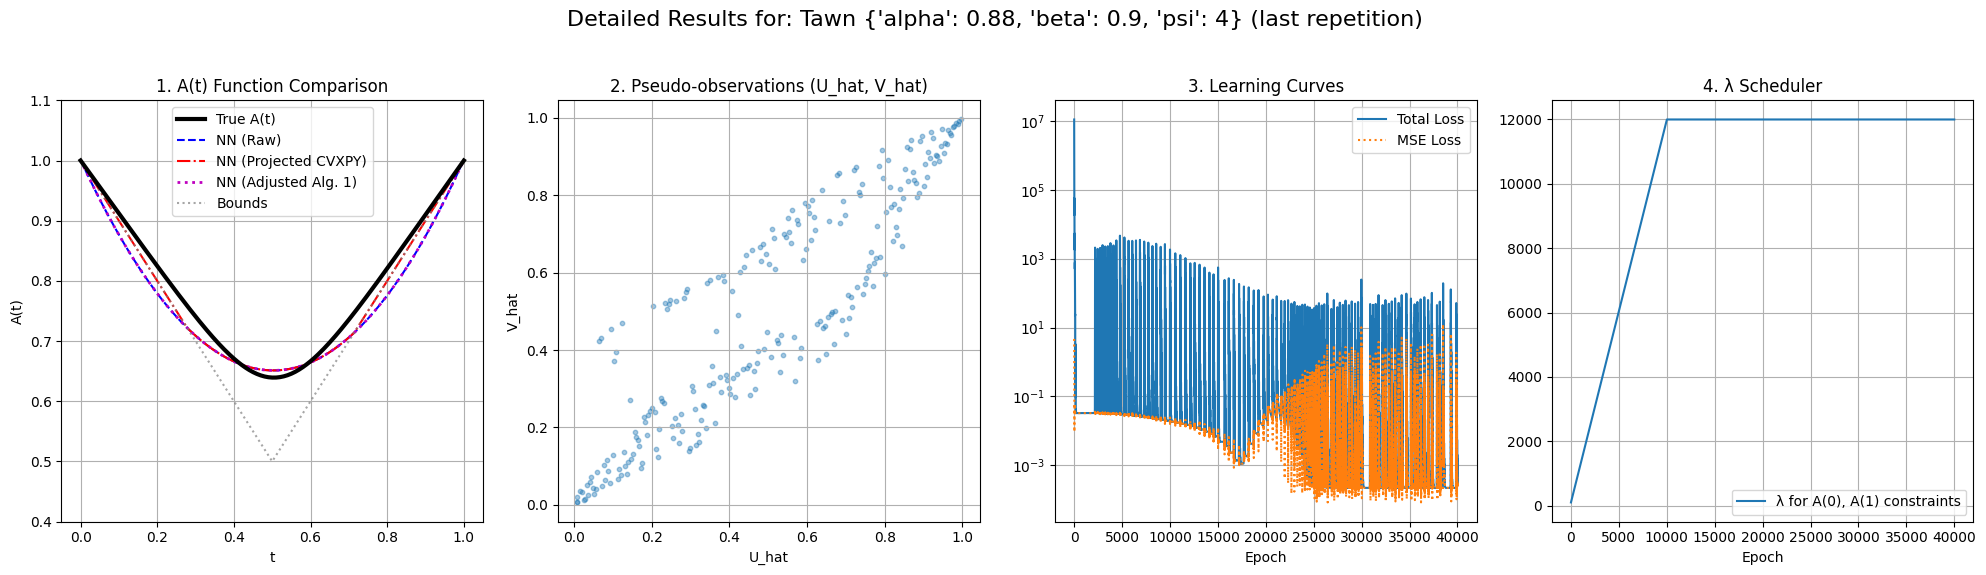


 STARTING SCENARIO: Tawn {'alpha': 1, 'beta': 0.9, 'psi': 4} (Tau ≈ 2.108)
[*] MAX_LAMBDA_A_BOUNDS adjusted for this scenario: 12000.0
--- Repetition 1/10 ---
-> Rep 1 finished. Duration: 49.54s. Raw MSE: 5.721e-03, Proj MSE: 1.013e-03, Adj MSE: 5.721e-03
--- Repetition 2/10 ---
-> Rep 2 finished. Duration: 51.76s. Raw MSE: 8.977e-04, Proj MSE: 1.898e-04, Adj MSE: 8.977e-04
--- Repetition 3/10 ---
-> Rep 3 finished. Duration: 46.25s. Raw MSE: 8.432e-04, Proj MSE: 2.135e-04, Adj MSE: 8.432e-04
--- Repetition 4/10 ---
-> Rep 4 finished. Duration: 45.94s. Raw MSE: 9.717e-04, Proj MSE: 2.347e-04, Adj MSE: 9.718e-04
--- Repetition 5/10 ---
-> Rep 5 finished. Duration: 45.68s. Raw MSE: 4.985e-04, Proj MSE: 3.065e-04, Adj MSE: 4.985e-04
--- Repetition 6/10 ---
-> Rep 6 finished. Duration: 45.61s. Raw MSE: 8.273e-04, Proj MSE: 2.004e-04, Adj MSE: 8.273e-04
--- Repetition 7/10 ---
-> Rep 7 finished. Duration: 45.24s. Raw MSE: 9.148e-04, Proj MSE: 2.187e-04, Adj MSE: 9.148e-04
--- Repetition 8/

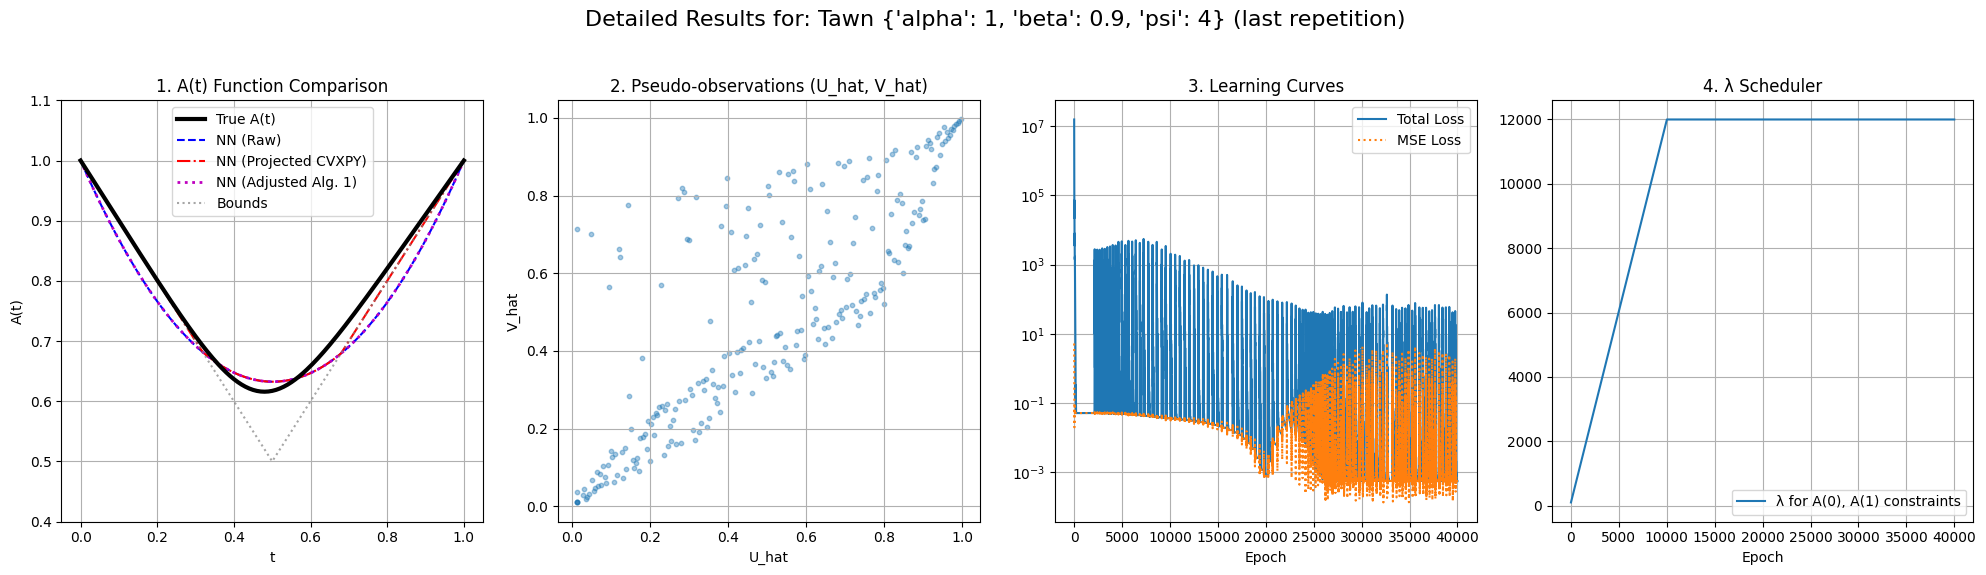


 STARTING SCENARIO: Tawn {'alpha': 0.8, 'beta': 0.8, 'psi': 1.1} (Tau ≈ 2.861)
[*] MAX_LAMBDA_A_BOUNDS adjusted for this scenario: 1000.0
--- Repetition 1/10 ---
-> Rep 1 finished. Duration: 45.45s. Raw MSE: 2.656e-04, Proj MSE: 1.956e-04, Adj MSE: 9.218e-03
--- Repetition 2/10 ---
-> Rep 2 finished. Duration: 44.82s. Raw MSE: 2.022e-05, Proj MSE: 2.019e-05, Adj MSE: 1.190e-01
--- Repetition 3/10 ---
-> Rep 3 finished. Duration: 44.99s. Raw MSE: 6.584e-04, Proj MSE: 4.640e-04, Adj MSE: 5.721e-03
--- Repetition 4/10 ---
-> Rep 4 finished. Duration: 45.18s. Raw MSE: 5.976e-06, Proj MSE: 5.956e-06, Adj MSE: 8.511e-02
--- Repetition 5/10 ---
-> Rep 5 finished. Duration: 44.75s. Raw MSE: 3.424e-03, Proj MSE: 3.051e-03, Adj MSE: 3.881e-01
--- Repetition 6/10 ---
-> Rep 6 finished. Duration: 44.82s. Raw MSE: 9.768e-06, Proj MSE: 9.738e-06, Adj MSE: 1.211e-01
--- Repetition 7/10 ---
-> Rep 7 finished. Duration: 45.41s. Raw MSE: 5.975e-06, Proj MSE: 5.956e-06, Adj MSE: 7.764e-02
--- Repetition

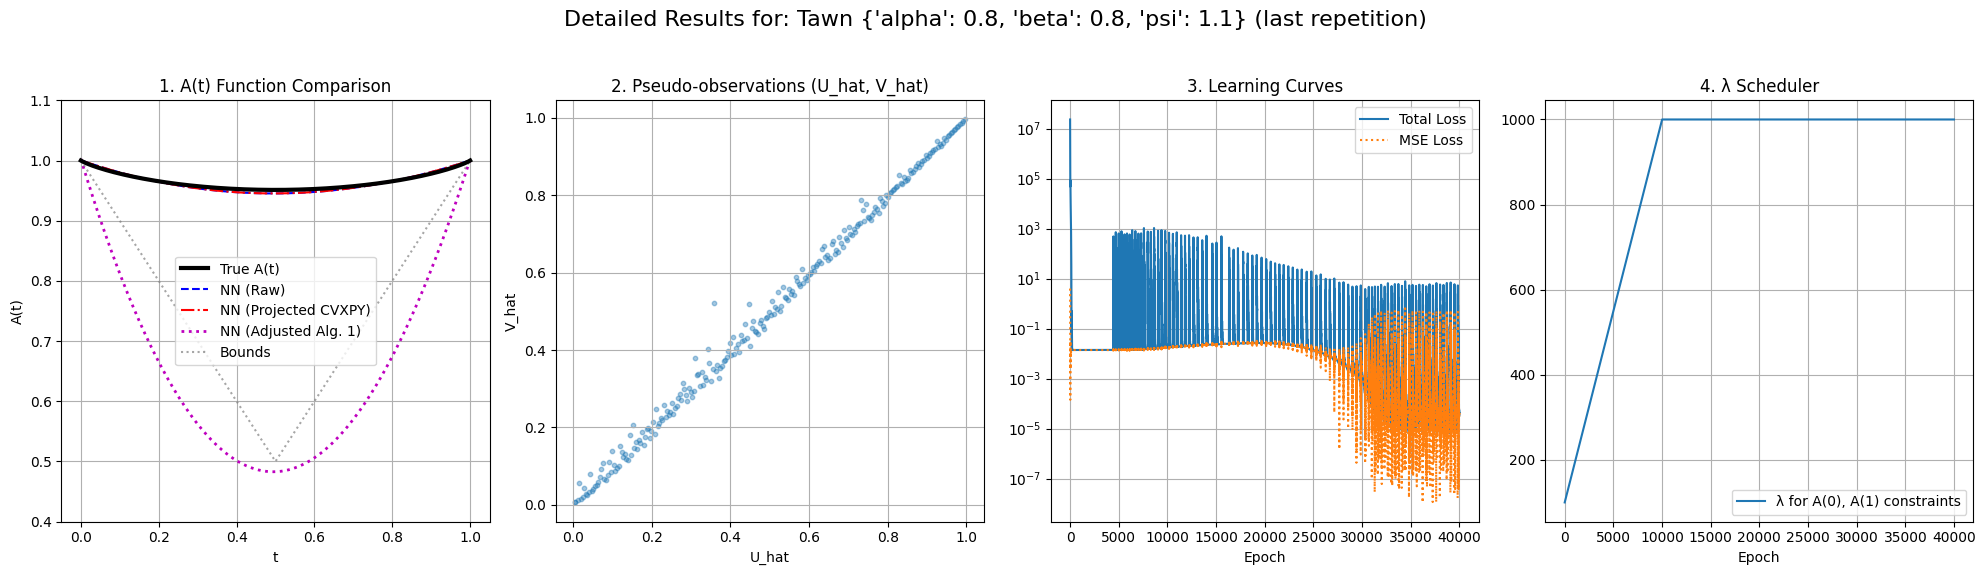


 STARTING SCENARIO: Tawn {'alpha': 0.8, 'beta': 0.8, 'psi': 1.52} (Tau ≈ 2.545)
[*] MAX_LAMBDA_A_BOUNDS adjusted for this scenario: 6000.0
--- Repetition 1/10 ---
-> Rep 1 finished. Duration: 44.92s. Raw MSE: 6.923e-05, Proj MSE: 6.922e-05, Adj MSE: 1.032e-02
--- Repetition 2/10 ---
-> Rep 2 finished. Duration: 46.11s. Raw MSE: 9.469e-06, Proj MSE: 9.469e-06, Adj MSE: 7.721e-03
--- Repetition 3/10 ---
-> Rep 3 finished. Duration: 42.54s. Raw MSE: 8.820e-02, Proj MSE: 1.533e-02, Adj MSE: 1.276e-01
--- Repetition 4/10 ---
-> Rep 4 finished. Duration: 42.63s. Raw MSE: 1.286e-05, Proj MSE: 1.286e-05, Adj MSE: 7.931e-03
--- Repetition 5/10 ---
-> Rep 5 finished. Duration: 43.41s. Raw MSE: 4.868e-04, Proj MSE: 4.370e-04, Adj MSE: 1.274e-02
--- Repetition 6/10 ---
-> Rep 6 finished. Duration: 42.95s. Raw MSE: 7.276e-04, Proj MSE: 7.255e-04, Adj MSE: 5.202e-03
--- Repetition 7/10 ---
-> Rep 7 finished. Duration: 42.69s. Raw MSE: 1.484e-05, Proj MSE: 1.484e-05, Adj MSE: 8.024e-03
--- Repetitio

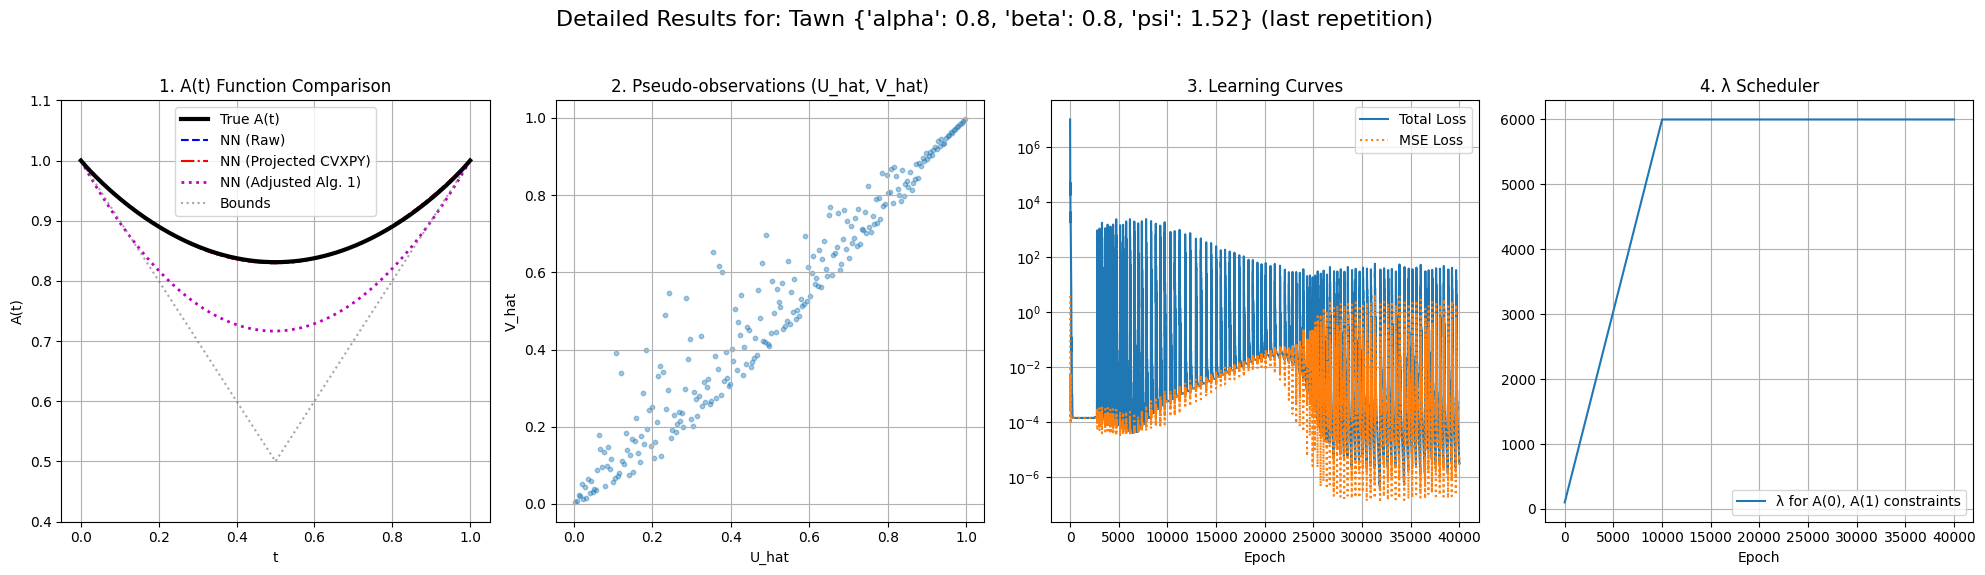


 STARTING SCENARIO: Tawn {'alpha': 0.8, 'beta': 0.8, 'psi': 7.0} (Tau ≈ 2.215)
[*] MAX_LAMBDA_A_BOUNDS adjusted for this scenario: 12000.0
--- Repetition 1/10 ---
-> Rep 1 finished. Duration: 45.69s. Raw MSE: 4.935e-03, Proj MSE: 2.017e-03, Adj MSE: 4.935e-03
--- Repetition 2/10 ---
-> Rep 2 finished. Duration: 43.38s. Raw MSE: 8.189e-01, Proj MSE: 5.046e-02, Adj MSE: 8.189e-01
--- Repetition 3/10 ---
-> Rep 3 finished. Duration: 43.16s. Raw MSE: 1.461e-03, Proj MSE: 8.792e-04, Adj MSE: 1.461e-03
--- Repetition 4/10 ---
-> Rep 4 finished. Duration: 43.13s. Raw MSE: 1.589e-03, Proj MSE: 9.240e-04, Adj MSE: 1.589e-03
--- Repetition 5/10 ---
-> Rep 5 finished. Duration: 43.30s. Raw MSE: 1.494e-03, Proj MSE: 8.884e-04, Adj MSE: 1.494e-03
--- Repetition 6/10 ---
-> Rep 6 finished. Duration: 43.39s. Raw MSE: 1.522e-03, Proj MSE: 8.969e-04, Adj MSE: 1.522e-03
--- Repetition 7/10 ---
-> Rep 7 finished. Duration: 43.37s. Raw MSE: 2.245e-01, Proj MSE: 4.070e-03, Adj MSE: 2.245e-01
--- Repetitio

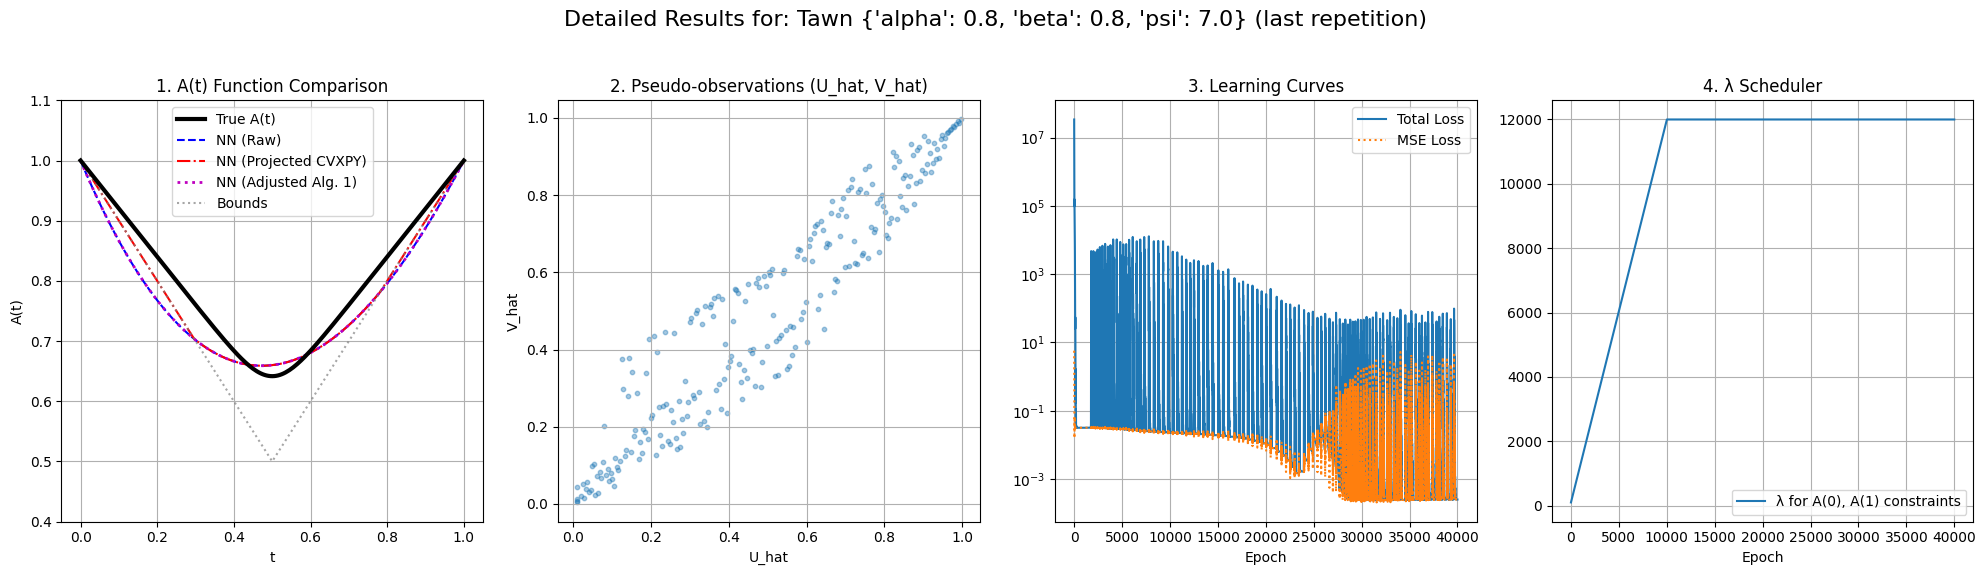


 STARTING SCENARIO: Tawn {'alpha': 0.8, 'beta': 0.8, 'psi': 20.0} (Tau ≈ 2.202)
[*] MAX_LAMBDA_A_BOUNDS adjusted for this scenario: 12000.0
--- Repetition 1/10 ---
-> Rep 1 finished. Duration: 42.66s. Raw MSE: 2.392e-03, Proj MSE: 1.204e-03, Adj MSE: 2.392e-03
--- Repetition 2/10 ---
-> Rep 2 finished. Duration: 42.91s. Raw MSE: 2.289e-03, Proj MSE: 1.175e-03, Adj MSE: 2.289e-03
--- Repetition 3/10 ---
-> Rep 3 finished. Duration: 42.76s. Raw MSE: 2.005e-03, Proj MSE: 1.115e-03, Adj MSE: 2.005e-03
--- Repetition 4/10 ---
-> Rep 4 finished. Duration: 43.17s. Raw MSE: 2.238e-03, Proj MSE: 1.167e-03, Adj MSE: 2.238e-03
--- Repetition 5/10 ---
-> Rep 5 finished. Duration: 43.15s. Raw MSE: 2.133e-03, Proj MSE: 1.141e-03, Adj MSE: 2.133e-03
--- Repetition 6/10 ---
-> Rep 6 finished. Duration: 42.92s. Raw MSE: 1.479e-01, Proj MSE: 3.403e-03, Adj MSE: 1.479e-01
--- Repetition 7/10 ---
-> Rep 7 finished. Duration: 43.07s. Raw MSE: 2.505e-03, Proj MSE: 1.247e-03, Adj MSE: 2.505e-03
--- Repetiti

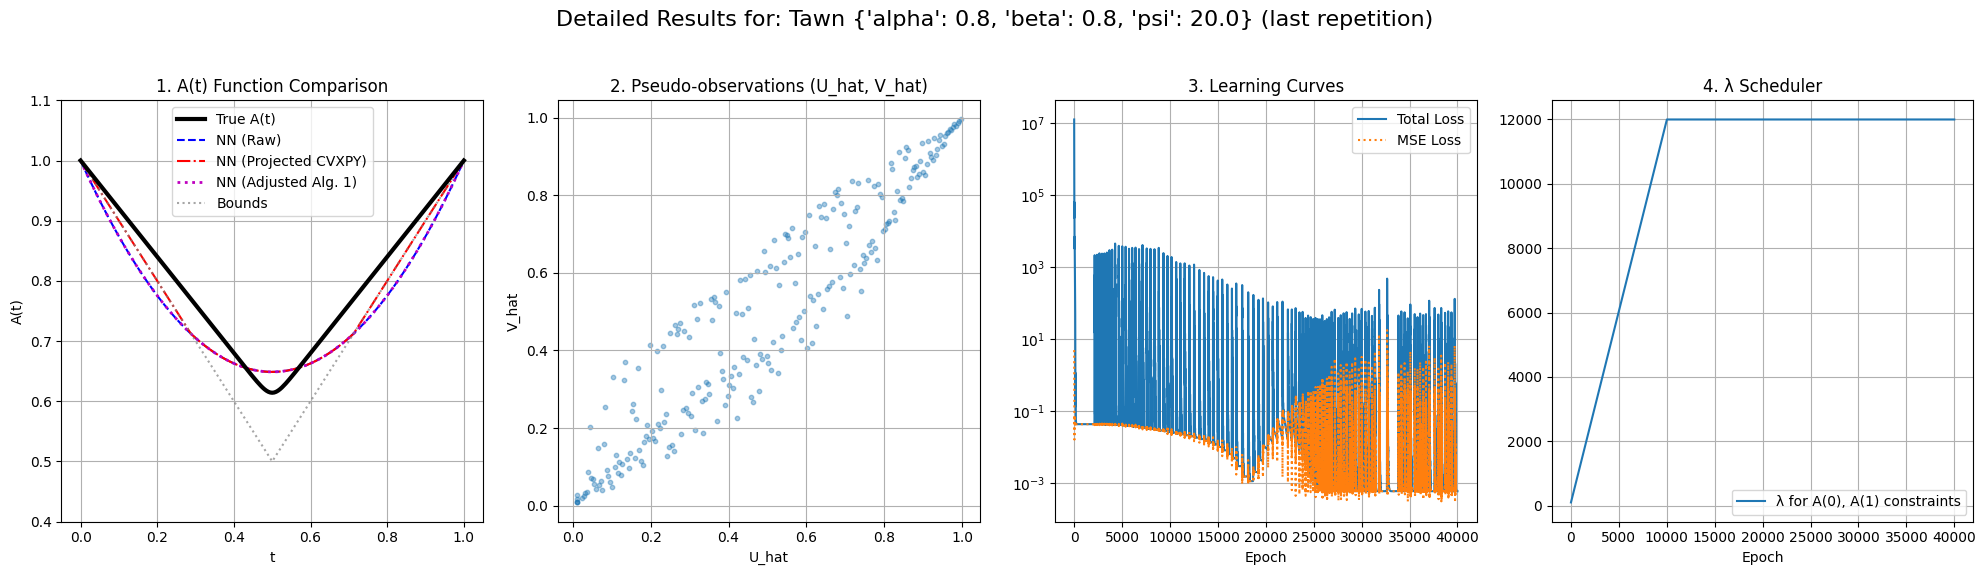


END OF ALL SIMULATIONS
Total duration: 9814.92 seconds.

Results saved to 'simulation_results_multicopula_adapted_lambda.csv'

--- Summary Statistics of MSE per Scenario ---
Scenario                   Galambos {'theta': 0.33}  Galambos {'theta': 1.0}  \
NN Raw MSE          count                1.0000e+01               1.0000e+01   
                    mean                 2.3490e-03               4.3976e-03   
                    std                  6.4608e-03               1.1496e-02   
                    min                  1.8072e-05               6.0695e-08   
                    25%                  2.0977e-05               1.4801e-06   
                    50%                  2.7690e-05               9.0091e-06   
                    75%                  1.5751e-04               4.1401e-04   
                    max                  2.0604e-02               3.6547e-02   
Projected CVXPY MSE count                1.0000e+01               1.0000e+01   
                    mean 

C:\Users\zargu\AppData\Local\Temp\ipykernel_2892\3652803457.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(data=df_long, x='Method', y='MSE', col='Scenario', col_wrap=4,


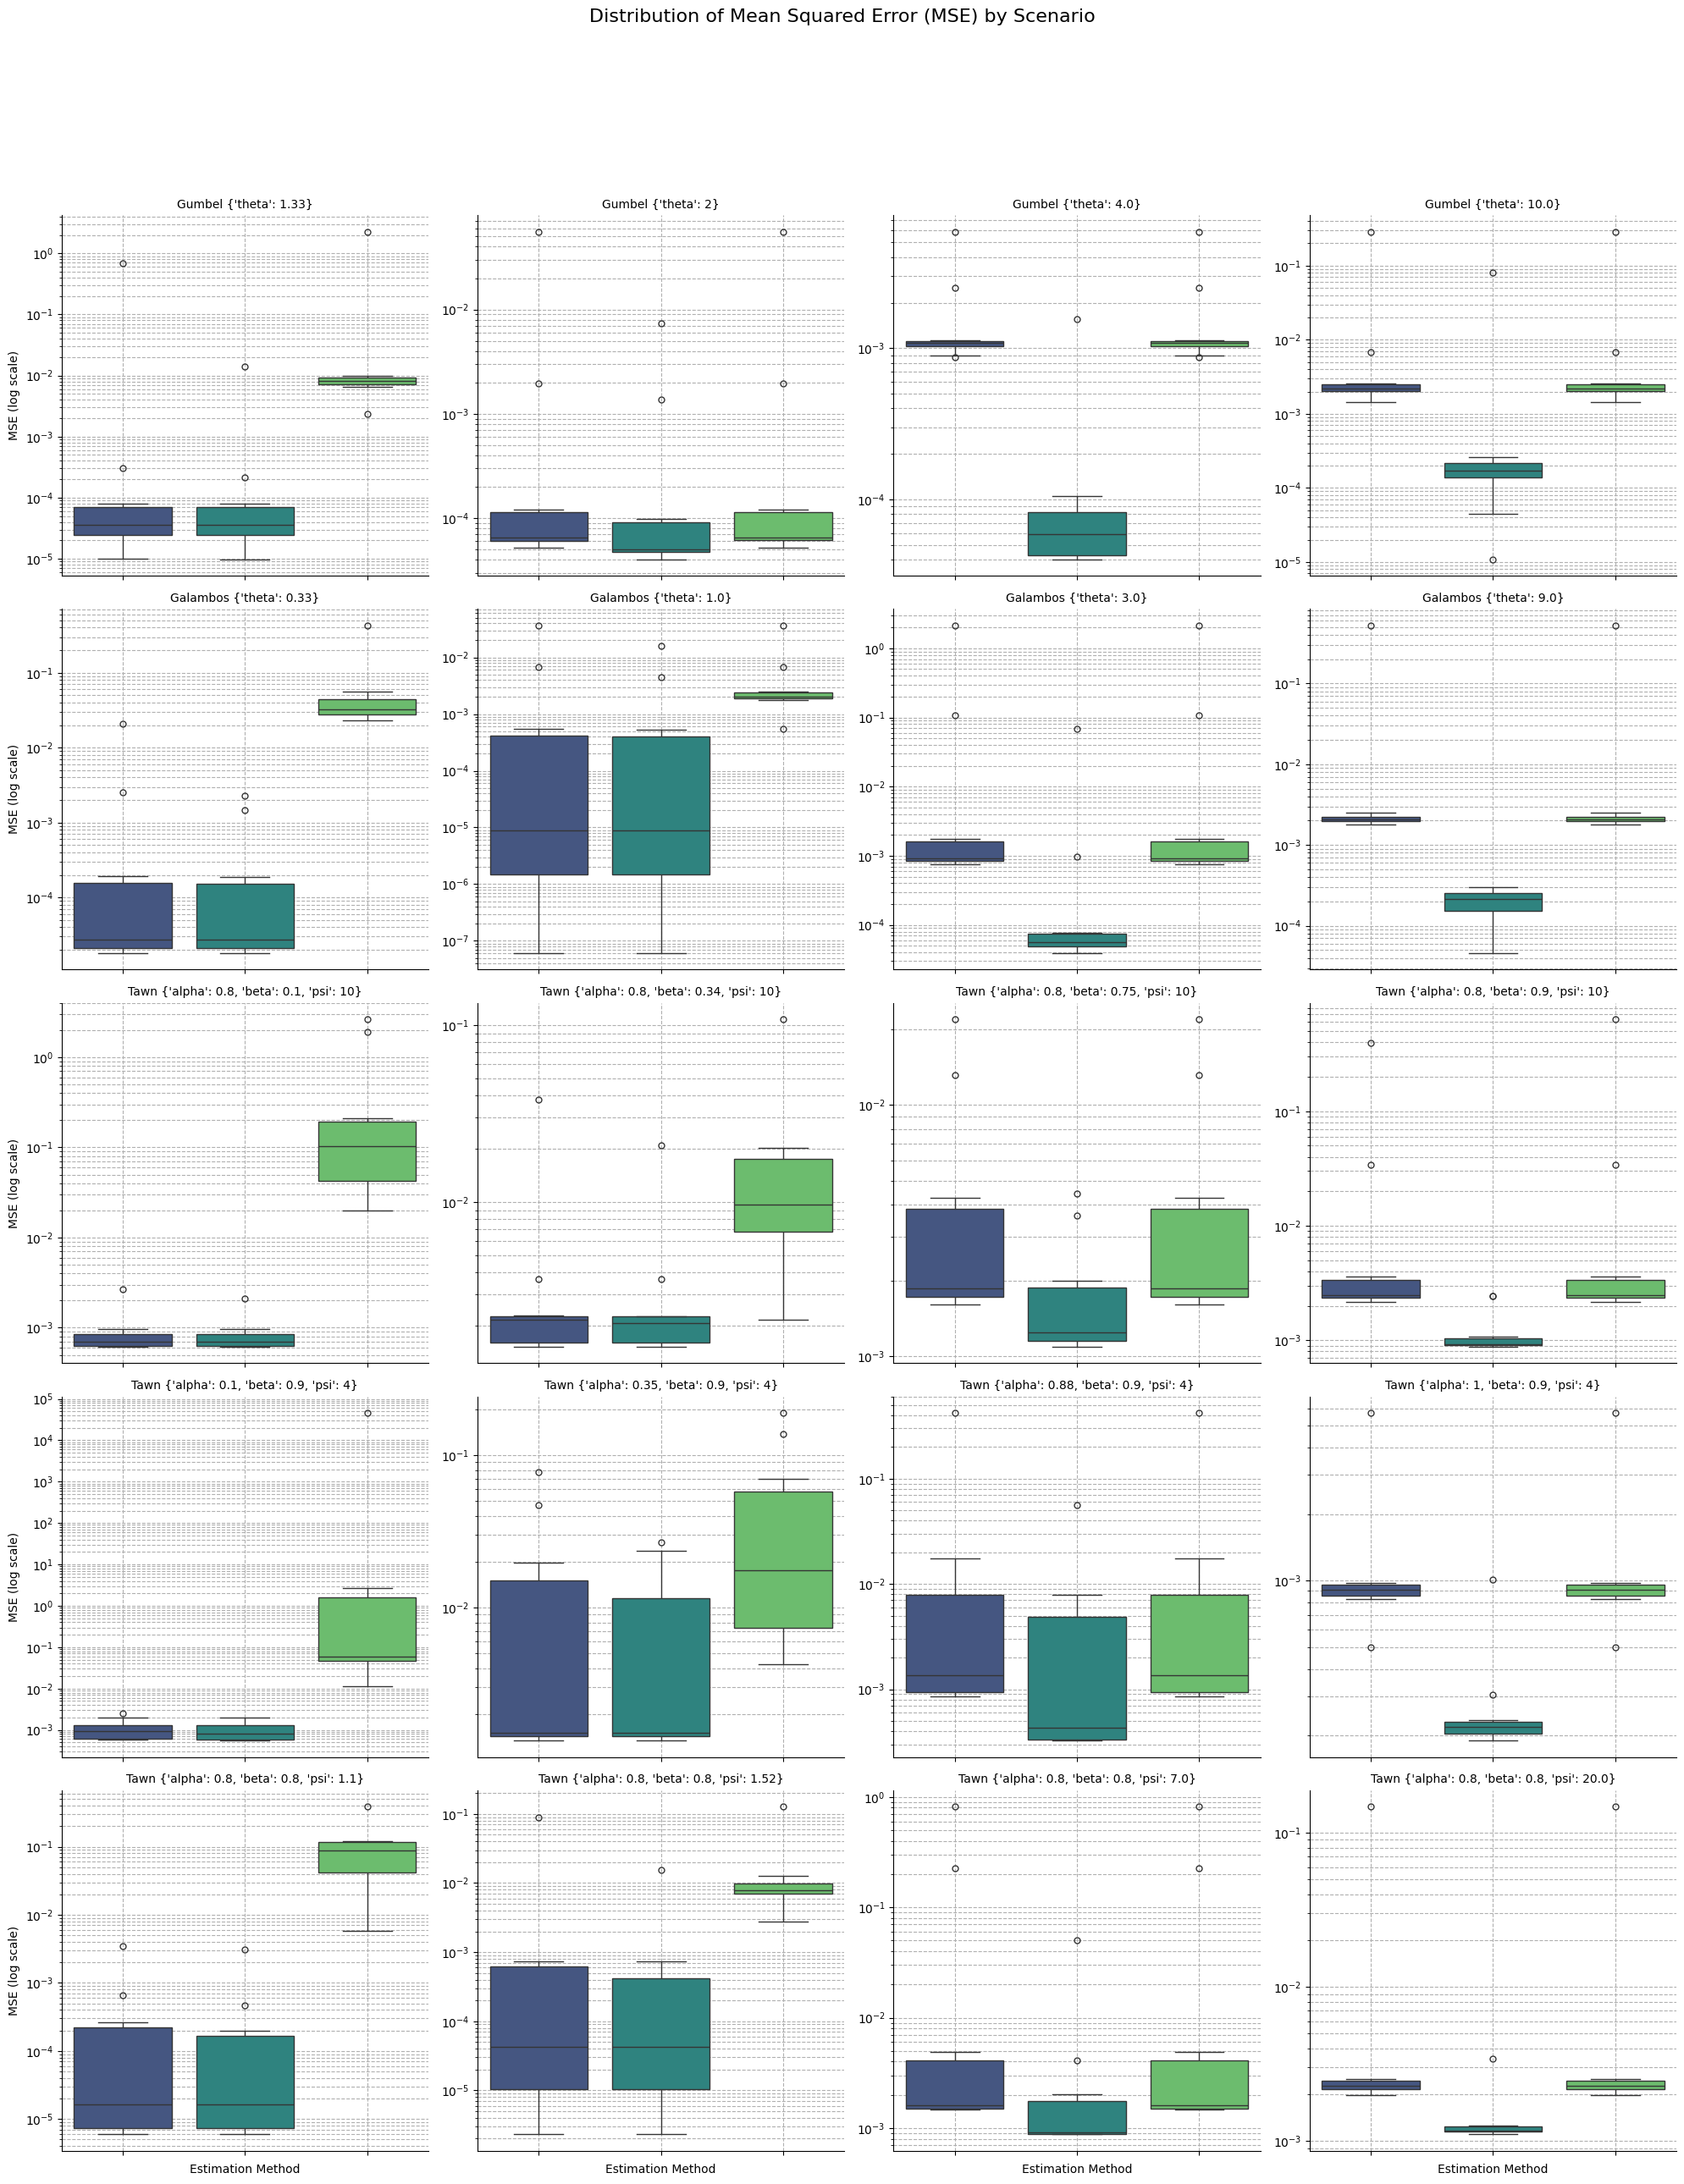

In [48]:
if __name__ == "__main__":
    # ... (SIMULATION_SCENARIOS definition remains the same) ...
    all_metrics_df = pd.DataFrame()
    simulation_start_time = time.time()
    
    for scenario in SIMULATION_SCENARIOS:
        scenario_name = f"{scenario['copula']} {scenario['params']}"
        tau = scenario['tau_fn'](**scenario['params'])
        
        print(f"\n{'='*25}\n STARTING SCENARIO: {scenario_name} (Tau ≈ {tau:.3f})\n{'='*25}") # TRANSLATED

        # --- Lambda adaptation logic remains the same ---
        if scenario['copula'] == 'Gumbel':
            theta = scenario['params']['theta']
            if theta <= 1.2: max_lambda_for_run = 1000.0
            elif theta <= 1.9: max_lambda_for_run = 6000.0
            else: max_lambda_for_run = 15000.0
        elif scenario['copula'] == 'Galambos':
            theta = scenario['params']['theta']
            if theta <= 0.9: max_lambda_for_run = 2000.0
            elif theta <= 1.5: max_lambda_for_run = 6000.0
            else: max_lambda_for_run = 12000.0
        elif scenario['copula'] == 'Tawn':
            psi = scenario['params']['psi']
            if psi <= 1.2: max_lambda_for_run = 1000.0
            elif psi <= 1.9: max_lambda_for_run = 6000.0
            else: max_lambda_for_run = 12000.0
        
        print(f"[*] MAX_LAMBDA_A_BOUNDS adjusted for this scenario: {max_lambda_for_run}") # TRANSLATED
        
        true_A_fn = partial(scenario['A_fn'], **scenario['params'])
        t_grid_eval_np = np.linspace(0.0, 1.0, 201).astype(np.float32)
        A_true_on_grid = true_A_fn(torch.from_numpy(t_grid_eval_np)).numpy()

        scenario_results = []
        for rep in range(N_REPETITIONS):
            start_time_rep = time.time()
            is_last_rep = (rep == N_REPETITIONS - 1)
            print(f"--- Repetition {rep + 1}/{N_REPETITIONS} ---") # TRANSLATED

            X_data, Y_data = generate_evc_data(true_A_fn, N_SAMPLES, margins='normal')
            t_data_train, U_hat, V_hat = get_pseudo_obs(X_data, Y_data)
            A_data_train_target = true_A_fn(torch.from_numpy(t_data_train)).numpy()
            model, history = train_model(t_data_train, A_data_train_target, 
                                         max_lambda=max_lambda_for_run,
                                         n_epochs=N_EPOCHS,
                                         quiet=(not is_last_rep))

            model.eval()
            with torch.no_grad():
                A_pred_nn = model(torch.from_numpy(t_grid_eval_np)).numpy()
            
            A_projected = project_to_valid_pickands_A_cvxpy(A_pred_nn, t_grid_eval_np)
            t_adj, beta_adj, alpha_adj = apply_algorithm_1(model)
            A_adjusted = evaluate_pickands_numpy(t_grid_eval_np, t_adj, beta_adj, alpha_adj)
            
            mse_raw = np.mean((A_pred_nn - A_true_on_grid)**2)
            mse_proj = np.mean((A_projected - A_true_on_grid)**2)
            mse_adj = np.mean((A_adjusted - A_true_on_grid)**2)
            
            scenario_results.append({
                "Scenario": scenario_name, "Repetition": rep + 1,
                "NN Raw MSE": mse_raw, 
                "Projected CVXPY MSE": mse_proj,
                "Adjusted Alg. 1 MSE": mse_adj
            }) # TRANSLATED KEYS
            
            print(f"-> Rep {rep + 1} finished. Duration: {time.time()-start_time_rep:.2f}s. Raw MSE: {mse_raw:.3e}, Proj MSE: {mse_proj:.3e}, Adj MSE: {mse_adj:.3e}") # TRANSLATED

            if is_last_rep:
                plot_results(model, history, A_projected, A_adjusted, t_grid_eval_np, true_A_fn, scenario_name, U_hat, V_hat)
        
        all_metrics_df = pd.concat([all_metrics_df, pd.DataFrame(scenario_results)], ignore_index=True)

    # --- End of all simulations ---
    print(f"\n{'='*50}\nEND OF ALL SIMULATIONS\n{'='*50}") # TRANSLATED
    print(f"Total duration: {time.time() - simulation_start_time:.2f} seconds.") # TRANSLATED
    
    csv_filename = "simulation_results_multicopula_adapted_lambda.csv"
    all_metrics_df.to_csv(csv_filename, index=False)
    print(f"\nResults saved to '{csv_filename}'") # TRANSLATED
    
    print("\n--- Summary Statistics of MSE per Scenario ---") # TRANSLATED
    with pd.option_context('display.precision', 4):
        # The column names are now in English, so this will work correctly
        summary = all_metrics_df.groupby('Scenario')[['NN Raw MSE', 'Projected CVXPY MSE', 'Adjusted Alg. 1 MSE']].describe().T
        print(summary)
        
    plot_simulation_summary(all_metrics_df)

### SECTION 6: Application to Real-World Data (Météo-France)

This section is dedicated to applying our methodology to real-world soil dryness (SWI) data from Météo-France.

#### Step 6.1: Data Loading and Geographic Preparation

We load the CSV files, clean the data, and then use `geopandas` to identify the Météo-France grid cells that correspond to the Gers and Nord departments. Finally, we select the grid cells closest to our target cities (e.g., Auch and Lille).

In [20]:
CHEMIN_DOSSIER_DONNEES = 'SWI_Package_1969-2024'

print("--- Début de l'analyse des données SWI depuis un dossier ---")

if not os.path.isdir(CHEMIN_DOSSIER_DONNEES):
    print("ERREUR")
    exit()

chemin_recherche = os.path.join(CHEMIN_DOSSIER_DONNEES, '*.csv')
liste_fichiers_csv = glob.glob(chemin_recherche)

if not liste_fichiers_csv:
    print(f"ERREUR : Aucun fichier .csv n'a été trouvé dans le dossier '{CHEMIN_DOSSIER_DONNEES}'.")
    exit()

print(f"Trouvé {len(liste_fichiers_csv)} fichiers CSV à traiter.")
print("Chargement et combinaison des fichiers en cours... (cela peut prendre un moment)")

start_time = time.time()

liste_dataframes = []
for fichier in liste_fichiers_csv:
    df_temp = pd.read_csv(fichier, delimiter=';')
    liste_dataframes.append(df_temp)

df = pd.concat(liste_dataframes, ignore_index=True)

end_time = time.time()
print(f" Tous les fichiers ont été chargés et combinés en {end_time - start_time:.2f} secondes.")

--- Début de l'analyse des données SWI depuis un dossier ---
Trouvé 40 fichiers CSV à traiter.
Chargement et combinaison des fichiers en cours... (cela peut prendre un moment)
 Tous les fichiers ont été chargés et combinés en 3.41 secondes.


In [21]:
print("\n--- 4. Prétraitement et Nettoyage des Données ---")

colonnes_a_renommer = {
    'NUMERO': 'numero', 'LAMBX': 'lambx', 'LAMBY': 'lamby',
    'DATE': 'date', 'SWI_UNIF_MENS': 'swi'
}
df.rename(columns={k: v for k, v in colonnes_a_renommer.items() if k in df.columns}, inplace=True)
print("Colonnes renommées.")

if pd.api.types.is_object_dtype(df['swi'].dtype):
    print("Conversion de la colonne 'swi' en numérique...")
    df['swi'] = df['swi'].str.replace(',', '.').astype(float)
    print("Colonne 'swi' convertie.")
elif pd.api.types.is_numeric_dtype(df['swi'].dtype):
    print("La colonne 'swi' est déjà au format numérique.")

if 'date' in df.columns:
    if not pd.api.types.is_datetime64_any_dtype(df['date'].dtype):
        print(f"La colonne 'date' n'est pas au format datetime (type actuel: {df['date'].dtype}). Conversion en cours...")
        df['date'] = pd.to_datetime(df['date'], format='%Y%m', utc=True)
        print("Colonne 'date' convertie avec succès.")
    else:
        print("La colonne 'date' est déjà au format datetime.")
else:
    print("La colonne 'date' est introuvable.")

df['annee'] = df['date'].dt.year
df['mois'] = df['date'].dt.month
print("Colonnes 'annee' et 'mois' créées.")

df.drop(columns=['date'], inplace=True)
print("Colonne 'date' intermédiaire supprimée.")

print("\nInformations sur le DataFrame final après nettoyage :")
df.info(memory_usage=False)
df.head()


--- 4. Prétraitement et Nettoyage des Données ---
Colonnes renommées.
Conversion de la colonne 'swi' en numérique...
Colonne 'swi' convertie.
La colonne 'date' n'est pas au format datetime (type actuel: int64). Conversion en cours...
Colonne 'date' convertie avec succès.
Colonnes 'annee' et 'mois' créées.
Colonne 'date' intermédiaire supprimée.

Informations sur le DataFrame final après nettoyage :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7005180 entries, 0 to 7005179
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   numero  int64  
 1   lambx   int64  
 2   lamby   int64  
 3   swi     float64
 4   annee   int32  
 5   mois    int32  
dtypes: float64(1), int32(2), int64(3)

numero   lambx    lamby    swi  annee  mois
0       2  641374  7106309  0.863   1960     1
1       2  641374  7106309  0.876   1960     2
2       2  641374  7106309  0.856   1960     3
3       2  641374  7106309  0.757   1960     4
4       2  641374  7106309  0.673   1960     5

In [22]:
def obtenir_numeros_mailles_par_departement(noms_departements, df_source):
    
    print(f"\n--- Étape 1 : Identification des mailles pour {noms_departements} ---")
    url_departements = "https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements.geojson"
    try:
        gdf_departements = geopandas.read_file(url_departements)[['nom', 'geometry']]
        print("Fond de carte des départements chargé.")
    except Exception as e:
        print(f"ERREUR de chargement du fond de carte : {e}")
        return None
        
    df_mailles_uniques = df_source[['numero', 'lambx', 'lamby']].drop_duplicates()
    gdf_mailles = geopandas.GeoDataFrame(
        df_mailles_uniques,
        geometry=geopandas.points_from_xy(df_mailles_uniques.lambx, df_mailles_uniques.lamby),
        crs="EPSG:2154" 
    )
    
    mailles_avec_departement = geopandas.sjoin(gdf_mailles, gdf_departements.to_crs(gdf_mailles.crs), how="inner", predicate="within")
    resultats = {}
    for nom_dep in noms_departements:
        numeros = mailles_avec_departement[mailles_avec_departement['nom'] == nom_dep]['numero'].tolist()
        resultats[nom_dep] = numeros
        print(f"{len(numeros)} numéros de mailles identifiés pour le département : {nom_dep}")
        
    return resultats
if 'df' in locals() and not df.empty:
    departements_a_chercher = ['Gers', 'Nord']
    mailles_par_departement = obtenir_numeros_mailles_par_departement(departements_a_chercher, df)
    
    if mailles_par_departement:
        print("\n--- Étape 2 : Création des DataFrames départementaux ---")
        numeros_gers = mailles_par_departement.get('Gers', [])
        if numeros_gers:
            df_gers = df[df['numero'].isin(numeros_gers)].copy()
            print(f"\nDataFrame 'df_gers' créé avec {len(df_gers)} lignes.")
            print("Aperçu de df_gers :")
            print(df_gers.head())
        numeros_nord = mailles_par_departement.get('Nord', [])
        if numeros_nord:
            df_nord = df[df['numero'].isin(numeros_nord)].copy()
            print(f"\nDataFrame 'df_nord' créé avec {len(df_nord)} lignes.")
            print("Aperçu de df_nord :")
            print(df_nord.head())


--- Étape 1 : Identification des mailles pour ['Gers', 'Nord'] ---
Fond de carte des départements chargé.
102 numéros de mailles identifiés pour le département : Gers
92 numéros de mailles identifiés pour le département : Nord

--- Étape 2 : Création des DataFrames départementaux ---

DataFrame 'df_gers' créé avec 79560 lignes.
Aperçu de df_gers :
         numero   lambx    lamby    swi  annee  mois
5761860    8282  507009  6331983  1.039   1960     1
5761861    8282  507009  6331983  0.985   1960     2
5761862    8282  507009  6331983  0.945   1960     3
5761863    8282  507009  6331983  0.811   1960     4
5761864    8282  507009  6331983  0.524   1960     5

DataFrame 'df_nord' créé avec 71760 lignes.
Aperçu de df_nord :
      numero   lambx    lamby    swi  annee  mois
1560       4  657366  7106175  0.869   1960     1
1561       4  657366  7106175  0.881   1960     2
1562       4  657366  7106175  0.859   1960     3
1563       4  657366  7106175  0.760   1960     4
1564       4  65

In [23]:
def identifier_mailles_proches_villes(df_departement, villes_cibles):
   
    if df_departement.empty:
        print(f"\n--- DataFrame départemental vide. Aucune recherche possible. ---")
        return pd.DataFrame()

    print(f"\n--- Recherche des mailles proches dans le département ---")

    liste_villes_a_creer = []
    for nom, details in villes_cibles.items():
        liste_villes_a_creer.append({
            'nom_commune': nom,
            'role': details['role'],
            'latitude': details['lat'],
            'longitude': details['lon']
        })
    df_villes = pd.DataFrame(liste_villes_a_creer)
    print("DataFrame des villes cibles créé localement.")

    mailles_uniques_dep = df_departement[['numero', 'lambx', 'lamby']].drop_duplicates()
    gdf_mailles = geopandas.GeoDataFrame(
        mailles_uniques_dep,
        geometry=geopandas.points_from_xy(mailles_uniques_dep.lambx, mailles_uniques_dep.lamby),
        crs="EPSG:2154"
    )
    gdf_villes = geopandas.GeoDataFrame(
        df_villes,
        geometry=geopandas.points_from_xy(df_villes.longitude, df_villes.latitude),
        crs="EPSG:4326"  
    )
    gdf_villes = gdf_villes.to_crs(gdf_mailles.crs)

    infos_mailles = []
    for _, ville_serie in gdf_villes.iterrows():
        ville_point = ville_serie.geometry
        distances = gdf_mailles.geometry.distance(ville_point)
        idx_plus_proche = distances.idxmin()
        maille_plus_proche = gdf_mailles.loc[idx_plus_proche]
        
        infos_mailles.append({
            'numero': maille_plus_proche.numero,
            'ville_proche': ville_serie.nom_commune,
            'role': ville_serie.role, 
            'distance_km': distances.min() / 1000
        })
        print(f"   -> Pour {ville_serie.nom_commune}, la maille la plus proche est n°{maille_plus_proche.numero} (à {distances.min()/1000:.2f} km)")

    numeros_selectionnes = [info['numero'] for info in infos_mailles]
    df_points_selectionnes = df_departement[df_departement['numero'].isin(numeros_selectionnes)].copy()

    df_infos = pd.DataFrame(infos_mailles)
    df_points_selectionnes = pd.merge(df_points_selectionnes, df_infos, on='numero')
    
    return df_points_selectionnes

if 'df_gers' in locals() and 'df_nord' in locals():

    # --- Gers Department ---
    villes_gers = {
        'Auch':             {'role': 'Center', 'lat': 43.6456, 'lon': 0.5857},
        'Condom':           {'role': 'North',  'lat': 43.9575, 'lon': 0.3735},
        'Mirande':          {'role': 'South',  'lat': 43.5152, 'lon': 0.4048},
        "L'Isle-Jourdain":  {'role': 'East',   'lat': 43.6143, 'lon': 1.0829},
        'Nogaro':           {'role': 'West',   'lat': 43.7573, 'lon': -0.0336}
    }
    df_gers_points = identifier_mailles_proches_villes(df_gers, villes_gers)
    
    if not df_gers_points.empty:
        print("\nDataFrame 'df_gers_points' created successfully!")
        print(df_gers_points[['numero', 'ville_proche', 'role']].drop_duplicates().reset_index(drop=True))

    # --- Nord Department ---
    villes_nord = {
        'Lille':         {'role': 'Center',          'lat': 50.6325, 'lon': 3.0576},
        'Dunkerque':     {'role': 'North (Coastal)', 'lat': 51.0344, 'lon': 2.3768},
        'Cambrai':       {'role': 'South',           'lat': 50.1764, 'lon': 3.2361},
        'Valenciennes':  {'role': 'East',            'lat': 50.3582, 'lon': 3.5233},
        'Hazebrouck':    {'role': 'West (Flanders)', 'lat': 50.7245, 'lon': 2.5386}
    }
    df_nord_points = identifier_mailles_proches_villes(df_nord, villes_nord)


--- Recherche des mailles proches dans le département ---
DataFrame des villes cibles créé localement.
   -> Pour Auch, la maille la plus proche est n°8824 (à 2.37 km)
   -> Pour Condom, la maille la plus proche est n°8372 (à 3.48 km)
   -> Pour Mirande, la maille la plus proche est n°8999 (à 3.74 km)
   -> Pour L'Isle-Jourdain, la maille la plus proche est n°8829 (à 2.72 km)
   -> Pour Nogaro, la maille la plus proche est n°8640 (à 3.11 km)

DataFrame 'df_gers_points' created successfully!
   numero     ville_proche    role
0    8372           Condom   North
1    8640           Nogaro    West
2    8824             Auch  Center
3    8829  L'Isle-Jourdain    East
4    8999          Mirande   South

--- Recherche des mailles proches dans le département ---
DataFrame des villes cibles créé localement.
   -> Pour Lille, la maille la plus proche est n°94 (à 1.91 km)
   -> Pour Dunkerque, la maille la plus proche est n°4 (à 2.07 km)
   -> Pour Cambrai, la maille la plus proche est n°237 (à 

#### Step 6.2: Marginal Modeling and Final Training

Here, we apply the most advanced methodology for the real-data case study:
1.  **`preparer_donnees_pour_copule`**: Transform the raw `Z` data into uniform `U(0,1)` pseudo-observations using a GPD model for the distribution tails.
2.  **`preparer_entrees_pour_reseau_pickands`**: Use these `U(0,1)` values to calculate the `t` inputs and the empirical `A(t)` target for the neural network.
3.  Finally, we train the model and visualize the results for the bivariate case studies.

In [25]:
def preparer_donnees_pour_copule(df_points_cibles, colonnes_analyse, titre_analyse=""):
    
    print(f"\n--- Préparation des données EVT pour la copule : {titre_analyse} ---")

    df_filtre = df_points_cibles[df_points_cibles['ville_proche'].isin(colonnes_analyse)]
    
    df_filtre['Z'] = -np.log(df_filtre['swi'].clip(lower=1e-5))
    date_components = df_filtre[['annee', 'mois']].assign(day=1).rename(columns={'annee': 'year', 'mois': 'month'})
    df_filtre['date_complete'] = pd.to_datetime(date_components)
    df_wide = df_filtre.pivot_table(index='date_complete', columns='ville_proche', values='Z').dropna()
    
    colonnes_villes = df_wide.columns.tolist()
    print(f"1. Données pivotées. Dimensions : {df_wide.shape}. Variables : {colonnes_villes}")

    
    pseudo_observations = pd.DataFrame(index=df_wide.index)
    for ville in colonnes_villes:
        series_z = df_wide[ville]
        seuil = series_z.quantile(0.90)
        corps = series_z[series_z <= seuil]
        queue = series_z[series_z > seuil]
        exces = queue - seuil
        
        prob_corps = corps.rank(pct=True) * 0.90
        
        if not exces.empty:
            shape, loc, scale = genpareto.fit(exces, floc=0)
            prob_queue_cond = genpareto.cdf(exces, c=shape, loc=loc, scale=scale)
            prob_queue = pd.Series(0.90 + 0.10 * prob_queue_cond, index=queue.index)
            pseudo_observations[ville] = pd.concat([prob_corps, prob_queue]).sort_index()
        else:
            pseudo_observations[ville] = prob_corps
            
    print("✅ Transformation en U(0,1) terminée.")
    return pseudo_observations.interpolate().dropna()

In [26]:
def preparer_entrees_pour_reseau_pickands(df_uniforme, paire_de_villes):
    
    if not all(v in df_uniforme.columns for v in paire_de_villes):
        print(f"ERROR: One of the cities {paire_de_villes} is not in the dataframe columns.")
        return None, None
        
    U, V = df_uniforme[paire_de_villes[0]], df_uniforme[paire_de_villes[1]]
    
    # Calculate radial (R) and angular (t) components
    S, T = -np.log(U.clip(1e-9, 1-1e-9)), -np.log(V.clip(1e-9, 1-1e-9))
    R, t_data = S + T, (S / (S + T)).dropna().astype(np.float32) 
    t_data = t_data[(t_data > 1e-5) & (t_data < 1-1e-5)]
    
    # Re-align R with the filtered t_data
    R = R[t_data.index]
    
    n = len(t_data)
    if n == 0:
        print("Warning: No valid data points after filtering `t`.")
        return None, None

    # This is the core of the new non-parametric estimator for A(t)
    A_target_hat = np.zeros(n)
    sorted_indices = np.argsort(t_data.values)
    R_sorted_by_t = R.iloc[sorted_indices]
    for i in range(n):
        # This formula estimates A at the i-th ordered t value
        A_target_hat[i] = R_sorted_by_t.iloc[i] * (n + 1) / (i + 2)
        
    # Re-order the A_target values to match the original order of t_data
    A_target_map = {t: a for t, a in zip(t_data.iloc[sorted_indices], A_target_hat)}
    A_target_ordered = np.array([A_target_map[t] for t in t_data]).astype(np.float32)
    
    # Clip the final target for stability
    t_values = t_data.values
    A_target_clipped = np.clip(A_target_ordered, np.maximum(t_values, 1-t_values), 1.0)
    
    return t_values, A_target_clipped


--- 11.1: Preparing data for the Auch vs. Lille case study ---

--- Préparation des données EVT pour la copule : Auch vs. Lille ---
1. Données pivotées. Dimensions : (780, 2). Variables : ['Auch', 'Lille']
✅ Transformation en U(0,1) terminée.

--- 11.2: Preparing NN inputs using the custom order-statistic estimator ---
Successfully generated 780 training pairs (t, A_target).

--- 11.3: Training the bivariate NN model on the new target ---
Epoch     0: Total Loss = 8.2850e+06 | MSE = 3.8187e+00
Epoch  8000: Total Loss = 9.2347e+01 | MSE = 1.4290e-02
Epoch 16000: Total Loss = 1.9135e-02 | MSE = 1.9133e-02
Epoch 24000: Total Loss = 2.3709e-02 | MSE = 2.3672e-02
Epoch 32000: Total Loss = 1.2573e-02 | MSE = 1.2014e-02
Epoch 39999: Total Loss = 1.1660e-02 | MSE = 1.1651e-02
Entraînement terminé.

--- 11.4: Generating final results and plots ---


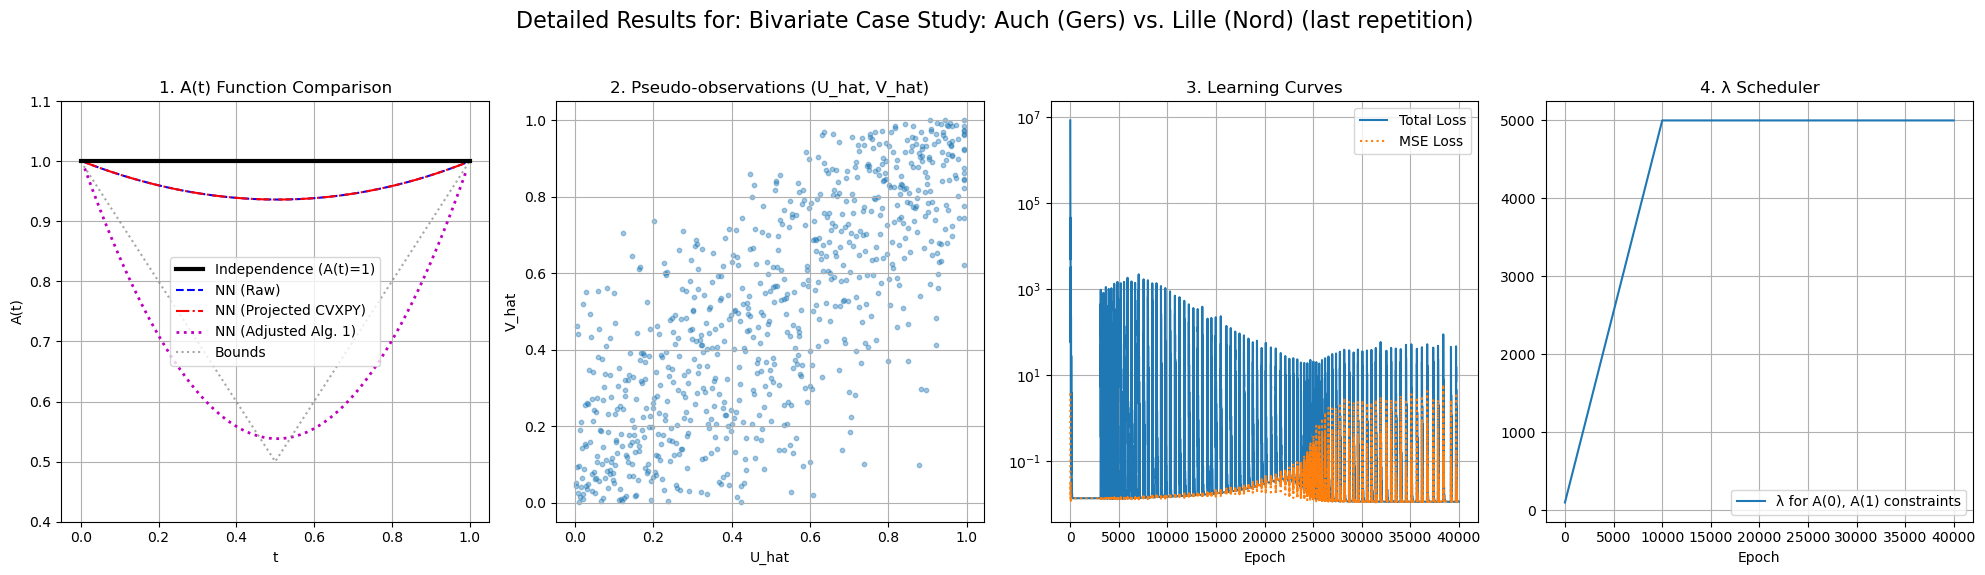

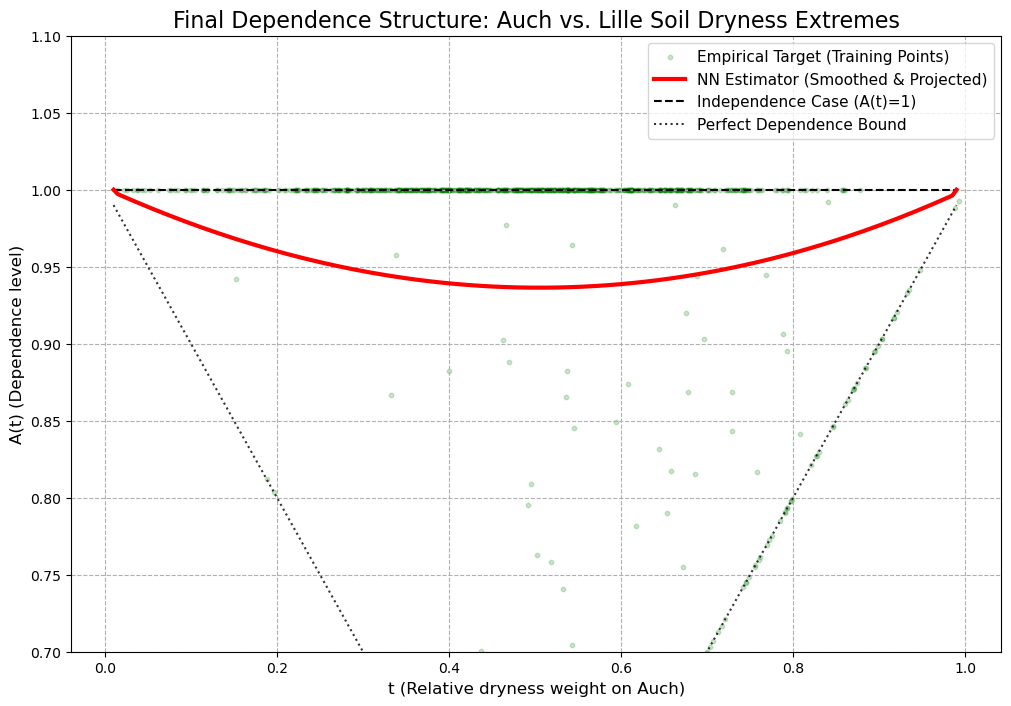

In [27]:
if 'df_gers_points' in locals() and 'df_nord_points' in locals():
    print("\n--- 11.1: Preparing data for the Auch vs. Lille case study ---")
    df_auch = df_gers_points[df_gers_points['ville_proche'] == 'Auch'].copy()
    df_lille = df_nord_points[df_nord_points['ville_proche'] == 'Lille'].copy()
    
    if df_auch.empty or df_lille.empty:
        print("ERROR: Could not find data for 'Auch' or 'Lille'.")
    else:
        df_bivariate_real = pd.concat([df_auch, df_lille], ignore_index=True)
        U_hat_bivariate = preparer_donnees_pour_copule(df_bivariate_real, ['Auch', 'Lille'], "Auch vs. Lille")

#GENERATE NN INPUTS USING THE NEW ESTIMATOR

if 'U_hat_bivariate' in locals() and not U_hat_bivariate.empty:
    print("\n--- 11.2: Preparing NN inputs using the custom order-statistic estimator ---")
    
    # Use your new function to get both t and A_target in one step
    t_data_real, A_target_real = preparer_entrees_pour_reseau_pickands(
        U_hat_bivariate, 
        ['Auch', 'Lille']
    )
    
    if t_data_real is not None:
        print(f"Successfully generated {len(t_data_real)} training pairs (t, A_target).")
        # We still need U_hat and V_hat for the scatter plot
        U_real_for_plot = U_hat_bivariate['Auch'].values
        V_real_for_plot = U_hat_bivariate['Lille'].values

# TRAIN THE BIVARIATE NEURAL NETWORK MODEL

if 't_data_real' in locals() and t_data_real is not None:
    print("\n--- 11.3: Training the bivariate NN model on the new target ---")
    
    model_real_bivariate, history_real_bivariate = train_model(
        t_data_real, 
        A_target_real,
        max_lambda=5000.0,
        n_epochs=N_EPOCHS,
        quiet=False
    )

#  FINAL PREDICTION, ADJUSTMENT, AND VISUALIZATION

if 'model_real_bivariate' in locals():
    print("\n--- 11.4: Generating final results and plots ---")
    
    t_grid_final = np.linspace(0.01, 0.99, 201)
    
    with torch.no_grad():
        A_pred_real = model_real_bivariate(torch.from_numpy(t_grid_final)).numpy()
        
    A_proj_real = project_to_valid_pickands_A_cvxpy(A_pred_real, t_grid_final)
    t_adj_real, beta_adj_real, alpha_adj_real = apply_algorithm_1(model_real_bivariate)
    A_adj_real = evaluate_pickands_numpy(t_grid_final, t_adj_real, beta_adj_real, alpha_adj_real)

    # Use the comprehensive plotting function
    plot_results(
        model=model_real_bivariate,
        history=history_real_bivariate,
        A_projected=A_proj_real,
        A_adjusted=A_adj_real,
        t_grid=t_grid_final,
        true_A_fn=lambda t: torch.ones_like(t),
        scenario_name="Bivariate Case Study: Auch (Gers) vs. Lille (Nord)",
        U_hat=U_real_for_plot,
        V_hat=V_real_for_plot, is_real_data=True
    )
    
    # A dedicated final plot 
    plt.figure(figsize=(12, 8))
    # We plot the training target points for context
    plt.scatter(t_data_real, A_target_real, color='green', alpha=0.2, s=10, label='Empirical Target (Training Points)')
    plt.plot(t_grid_final, A_proj_real, 'r-', linewidth=3, label='NN Estimator (Smoothed & Projected)', zorder=10)
    plt.plot(t_grid_final, np.ones_like(t_grid_final), 'k--', label='Independence Case (A(t)=1)')
    plt.plot(t_grid_final, np.maximum(t_grid_final, 1-t_grid_final), 'k:', alpha=0.8, label='Perfect Dependence Bound')
    
    plt.title("Final Dependence Structure: Auch vs. Lille Soil Dryness Extremes", fontsize=16)
    plt.xlabel("t (Relative dryness weight on Auch)", fontsize=12)
    plt.ylabel("A(t) (Dependence level)", fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, which="both", ls="--")
    plt.ylim(0.7, 1.1)
    plt.show()


--- 11.1: Preparing data for the Auch vs. Lille case study ---

--- Préparation des données EVT pour la copule : Auch vs. Mirande ---
1. Données pivotées. Dimensions : (780, 2). Variables : ['Auch', 'Mirande']
✅ Transformation en U(0,1) terminée.

--- 11.2: Preparing NN inputs using the custom order-statistic estimator ---
Successfully generated 780 training pairs (t, A_target).

--- 11.3: Training the bivariate NN model on the new target ---
Epoch     0: Total Loss = 1.5304e+07 | MSE = 4.0422e+00
Epoch  8000: Total Loss = 2.4407e-02 | MSE = 2.4380e-02
Epoch 16000: Total Loss = 3.2199e-02 | MSE = 3.2099e-02
Epoch 24000: Total Loss = 5.9271e-02 | MSE = 5.9222e-02
Epoch 32000: Total Loss = 1.8526e-02 | MSE = 1.8522e-02
Epoch 39999: Total Loss = 1.8584e-02 | MSE = 1.8577e-02
Entraînement terminé.

--- 11.4: Generating final results and plots for the paper ---


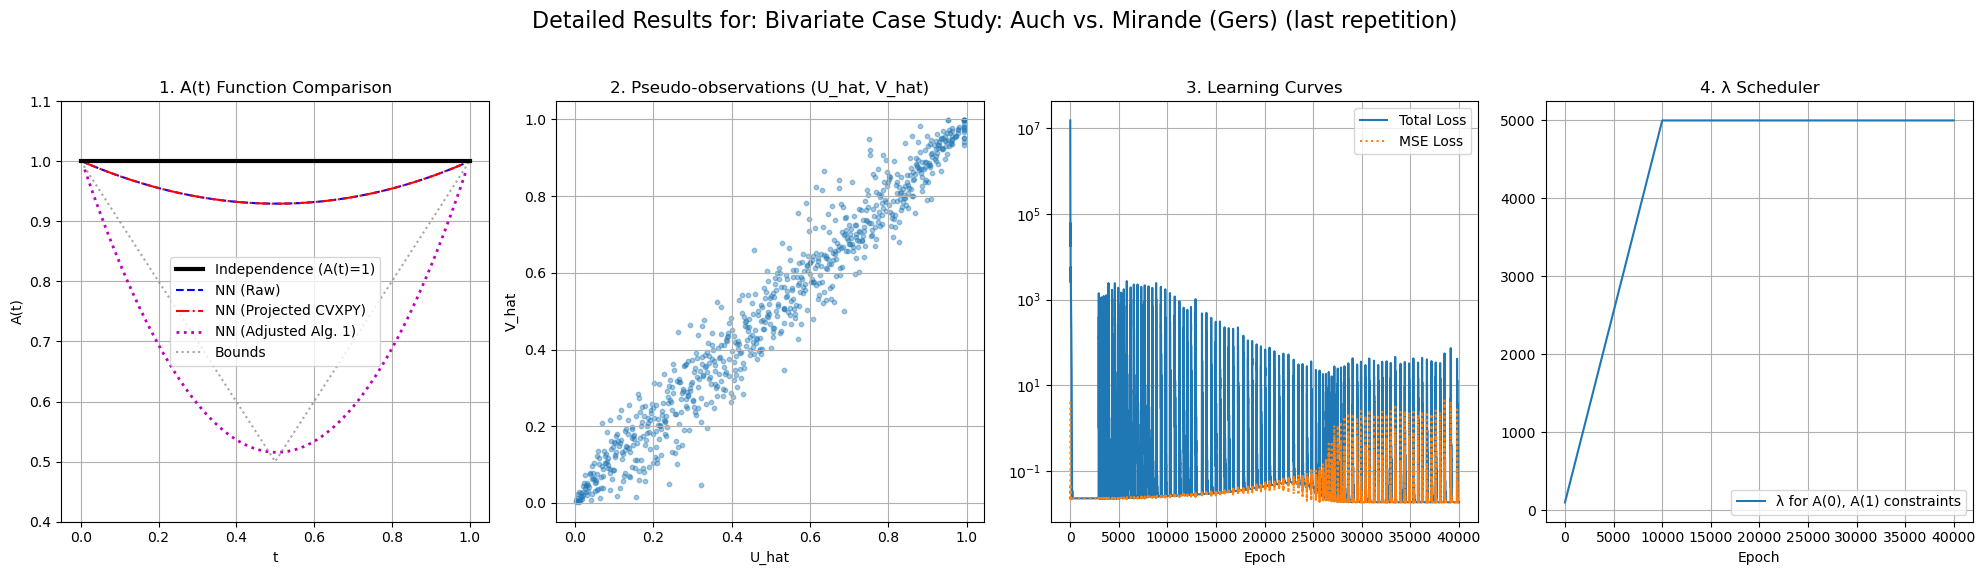

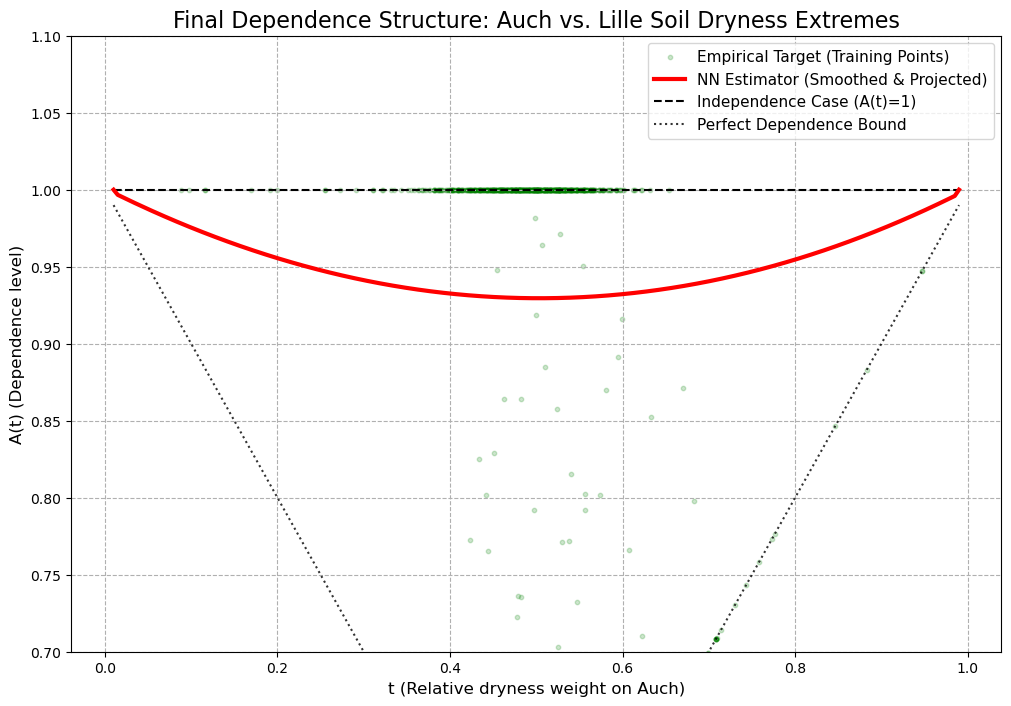

In [28]:
if 'df_gers_points' in locals() and 'df_nord_points' in locals():
    print("\n--- 11.1: Preparing data for the Auch vs. Lille case study ---")
    df_auch = df_gers_points[df_gers_points['ville_proche'] == 'Auch'].copy()
    df_Mirande = df_gers_points[df_gers_points['ville_proche'] == 'Mirande'].copy()
    
    if df_auch.empty or df_Mirande.empty:
        print("ERROR: Could not find data for 'Auch' or 'Mirande'.")
    else:
        df_bivariate_real = pd.concat([df_auch, df_Mirande], ignore_index=True)
        U_hat_bivariate = preparer_donnees_pour_copule(df_bivariate_real, ['Auch', 'Mirande'], "Auch vs. Mirande")

# GENERATE NN INPUTS USING THE NEW ESTIMATOR

if 'U_hat_bivariate' in locals() and not U_hat_bivariate.empty:
    print("\n--- 11.2: Preparing NN inputs using the custom order-statistic estimator ---")
    
    # Use your new function to get both t and A_target in one step
    t_data_real, A_target_real = preparer_entrees_pour_reseau_pickands(
        U_hat_bivariate, 
        ['Auch', 'Mirande']
    )
    
    if t_data_real is not None:
        print(f"Successfully generated {len(t_data_real)} training pairs (t, A_target).")
        # We still need U_hat and V_hat for the scatter plot
        U_real_for_plot = U_hat_bivariate['Auch'].values
        V_real_for_plot = U_hat_bivariate['Mirande'].values

# STEP 11.3: TRAIN THE BIVARIATE NEURAL NETWORK MODEL

if 't_data_real' in locals() and t_data_real is not None:
    print("\n--- 11.3: Training the bivariate NN model on the new target ---")
    
    model_real_bivariate, history_real_bivariate = train_model(
        t_data_real, 
        A_target_real,
        max_lambda=5000.0,
        n_epochs=N_EPOCHS,
        quiet=False
    )


#  FINAL PREDICTION, ADJUSTMENT, AND VISUALIZATION

if 'model_real_bivariate' in locals():
    print("\n--- 11.4: Generating final results and plots for the paper ---")
    
    t_grid_final = np.linspace(0.01, 0.99, 201)
    
    with torch.no_grad():
        A_pred_real = model_real_bivariate(torch.from_numpy(t_grid_final)).numpy()
        
    A_proj_real = project_to_valid_pickands_A_cvxpy(A_pred_real, t_grid_final)
    t_adj_real, beta_adj_real, alpha_adj_real = apply_algorithm_1(model_real_bivariate)
    A_adj_real = evaluate_pickands_numpy(t_grid_final, t_adj_real, beta_adj_real, alpha_adj_real)

    # Use the comprehensive plotting function
    plot_results(
        model=model_real_bivariate,
        history=history_real_bivariate,
        A_projected=A_proj_real,
        A_adjusted=A_adj_real,
        t_grid=t_grid_final,
        true_A_fn=lambda t: torch.ones_like(t),
        scenario_name="Bivariate Case Study: Auch vs. Mirande (Gers)",
        U_hat=U_real_for_plot,
        V_hat=V_real_for_plot, is_real_data=True
    )
    
    # A dedicated final plot for the paper
    plt.figure(figsize=(12, 8))
    # We plot the training target points for context
    plt.scatter(t_data_real, A_target_real, color='green', alpha=0.2, s=10, label='Empirical Target (Training Points)')
    plt.plot(t_grid_final, A_proj_real, 'r-', linewidth=3, label='NN Estimator (Smoothed & Projected)', zorder=10)
    plt.plot(t_grid_final, np.ones_like(t_grid_final), 'k--', label='Independence Case (A(t)=1)')
    plt.plot(t_grid_final, np.maximum(t_grid_final, 1-t_grid_final), 'k:', alpha=0.8, label='Perfect Dependence Bound')
    
    plt.title("Final Dependence Structure: Auch vs. Lille Soil Dryness Extremes", fontsize=16)
    plt.xlabel("t (Relative dryness weight on Auch)", fontsize=12)
    plt.ylabel("A(t) (Dependence level)", fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, which="both", ls="--")
    plt.ylim(0.7, 1.1)
    plt.show()